In [1]:
"""
Written by: Tommy Banker (thomas_banker@berkeley.edu)
"""

import os
import json
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from utils import *




matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            'figure.dpi' : 300,

                            })

font = {'weight' : 'bold',
        'size'   : 34}
plt.rc('font', **font)





In [2]:
methods = ['Malaria', ]
best_list = {'cep': 11.086613 }
best = 0#2.70805020110221 #best_list['cep']
seeds = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,]


In [3]:
sample_configs = [r'./config/malaria/Malaria_SAAS_0.json',
                 r'./config/malaria/Malaria_GP_full_0.json',
                 r'./config/malaria/Malaria_GP_pca_0.json',
                 r'./config/malaria/Malaria_linear_0.json', 
                 r'./config/malaria/Malaria_Random_0.json']

names = ['SAAS','GP_full','GP_PCA', 'Linear' ,'random']
names2 = ['MolDAIS','SGP',"SGP-PCA", 'SLR' ,'Random']

Res_dict_raw = {'SAAS':[], 'GP_full':[],'GP_PCA':[],'Linear':[] , 'random':[]}        
Res_dict_stat = {'SAAS':[], 'GP_full':[],'GP_PCA':[],'Linear':[] , 'random':[]}               
Smi_dict_stat = {'SAAS':[], 'GP_full':[],'GP_PCA':[],'Linear':[] , 'random':[]}               


for i100,sample_config in enumerate(sample_configs):        
    with open(sample_config) as f:
        exp_config = json.load(f)
    ########    
    y_variable = exp_config['common']['y_variable']
    max_min = exp_config['common']['max_min']
    init_budget = exp_config['common']['init_budget']
    total_budget = exp_config['common']['total_budget']
    bo_iters = np.arange(1, total_budget - init_budget + 1)
    ########
    all_results = np.zeros((len(methods), len(seeds), total_budget))
    smi_results = []
    sorted_results = np.zeros((len(methods), len(seeds), total_budget - init_budget + 1))
    conv_results = np.zeros((len(methods), (total_budget - init_budget + 1), 2))
    ########
    for i, method in enumerate(methods):
        for j, seed in enumerate(seeds):
            exp_config['exp_name'] = method #+ '_' + str(seed) 
            exp_config['seed'] = seed
            path = os.path.join('../results/', 'Malaria',)
            if i100==3 : 
                filename = f'Malaria_max_activity_Linear_seed_{seed}_bo-iter_90_10_to_100_samples_None_None_None'
            else: 
                filename = get_filename(bo_iters[-1], exp_config)
                filename = 'M'+filename[1:]
            result = torch.load(os.path.join(path, filename + '.pkl'))
            all_results[i,j,:] = result['y_train'].squeeze()
            smi_results.append( result['smiles_train'])
    ########
    sorted_results[:,:,0] = np.max(all_results[:,:,:init_budget], axis=2)
    for i, method in enumerate(methods):
        for j, seed in enumerate(seeds):
            for sample in np.arange(total_budget - init_budget):
                if all_results[i,j,(init_budget + sample)] > sorted_results[i,j,sample]:
                    sorted_results[i,j,(sample + 1)] = all_results[i,j,(init_budget + sample)]
                else:
                    sorted_results[i,j,(sample + 1)] = sorted_results[i,j,(sample)]
    ########
    for i, method in enumerate(methods):
        for sample in np.arange(total_budget - init_budget + 1):
            conv_results[i,sample,0] = np.mean(sorted_results[i,:,sample])
            conv_results[i,sample,1] = np.std(sorted_results[i,:,sample])
    ########
    sample_numbers = np.arange(total_budget - init_budget + 1)
    #max_min_vars = torch.load('../prop_data/max_min_vars.pkl')
    if max_min == 'max':
        conv_results[:,:,0] =conv_results[:,:,0]# (conv_results[:,:,0] )*-1 + best #- max_min_vars[y_variable]['max']) * -1
    else:   # convention appears strange bc results as stored are already the
            # negative of the true values to perform minimization experiments
        conv_results[:,:,0] = (conv_results[:,:,0] - -1 * max_min_vars[y_variable]['min']) * -1
    
    
    Res_dict_raw[names[i100]] = sorted_results
    Res_dict_stat[names[i100]] = conv_results    
    Smi_dict_stat[names[i100]] = smi_results

In [4]:
Res_dict_raw['SAAS']

import pickle 

with open('./DataFiles/malaria_results.pkl', 'wb') as f:
    pickle.dump(Res_dict_raw, f)

/tmp/ipykernel_1122925/2431614412.py:11: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(sample_numbers, conv_results[0,:,0], style, linewidth=3, label=names2[i], c=colors[i])


"\nfig = plt.figure(figsize=(12,9))\nfor i, method in enumerate(names):\n    style = '-'\n    conv_results = Res_dict_stat[method]\n    plt.plot(sample_numbers, conv_results[0,:,0], style, linewidth=3, label=names2[i], c=colors[i])\n    plt.fill_between(sample_numbers, conv_results[0,:,0]-(1.95*conv_results[0,:,1]/(len(seeds)**0.5)), conv_results[0,:,0]+(1.95*conv_results[0,:,1]/(len(seeds)**0.5)), alpha=0.1, color=colors[i])\nplt.legend(loc=0)\n#plt.title('Convergence Results Across ' + str(len(seeds)) + ' Runs with ' + str(init_budget) + ' Initial Random Samples')\nplt.xlabel('Iterations')\nplt.ylabel('Regret' )\nplt.yscale('log')\n#plt.xlim(0,60)    \n#plt.ylim(0,1)    \nplt.xlim(0,90)\nplt.savefig('./figs/malaria/Convergence_log.png')\n        "

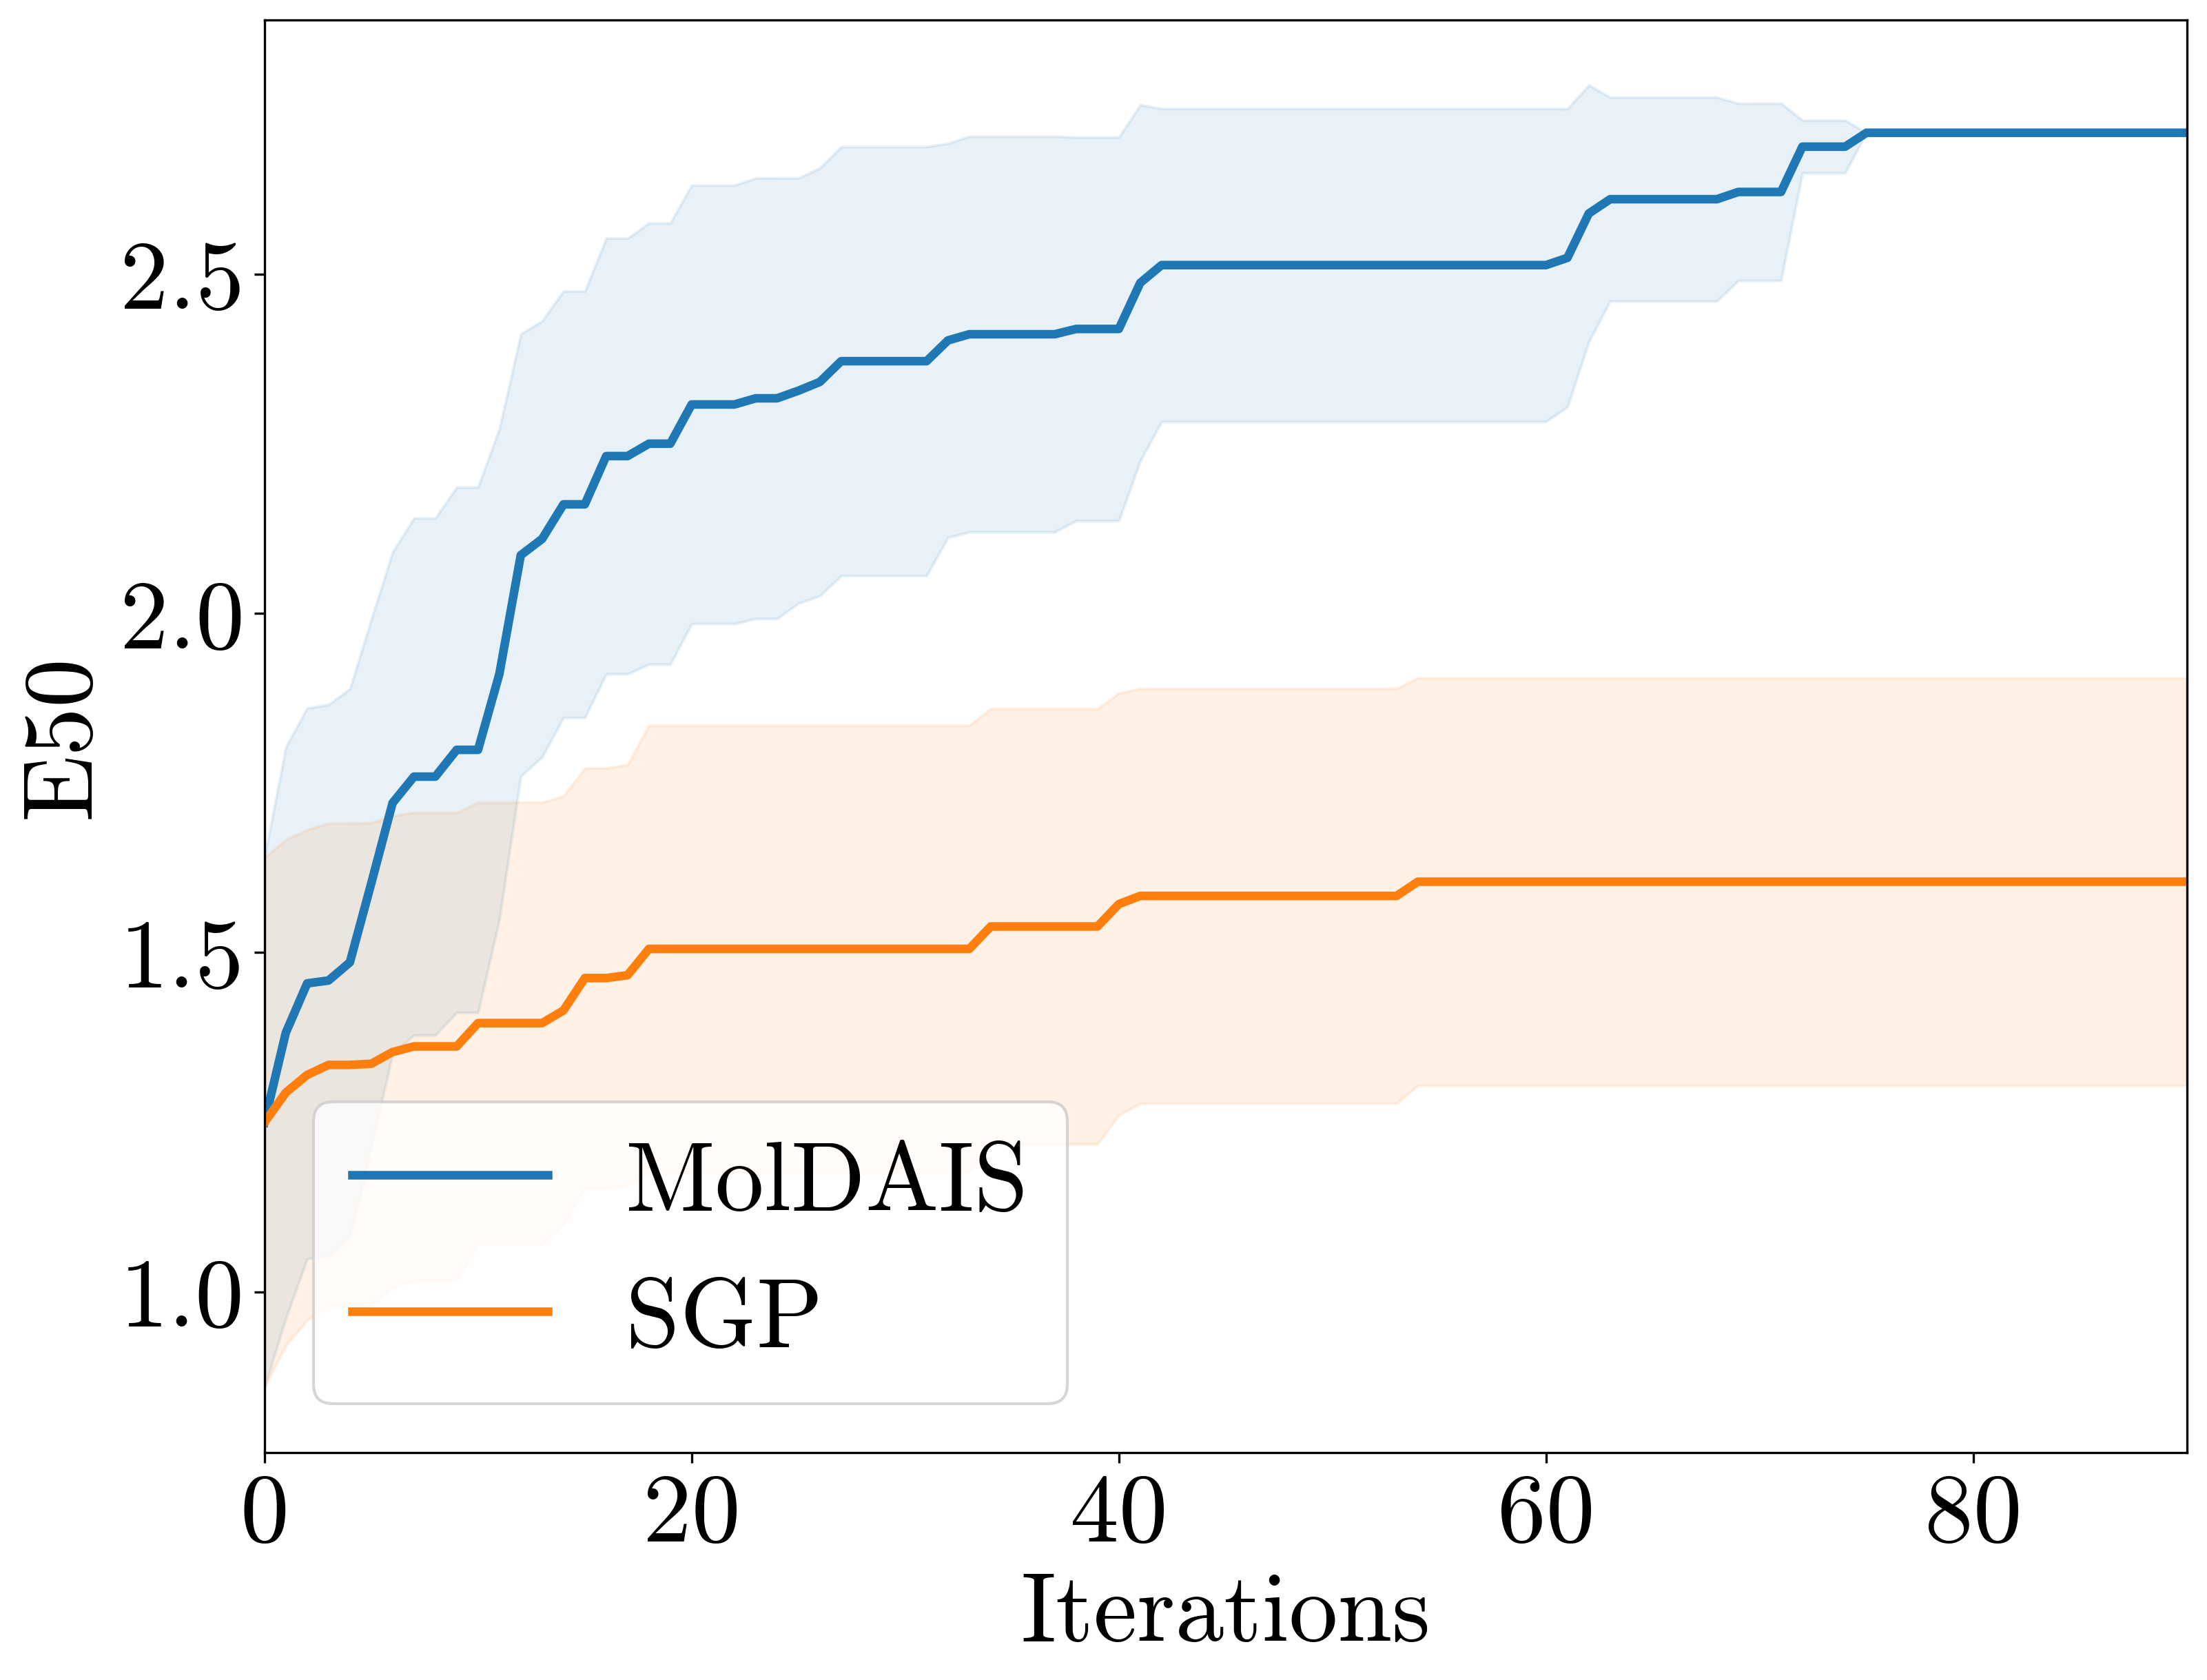

In [7]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#01015c','#0302FC', ] 

names = ['SAAS','GP_full', ]
names2 = ['MolDAIS','SGP',]


fig = plt.figure(figsize=(12,9))
for i, method in enumerate(names):
    style = '-'
    conv_results = Res_dict_stat[method]
    plt.plot(sample_numbers, conv_results[0,:,0], style, linewidth=3, label=names2[i], c=colors[i])
    plt.fill_between(sample_numbers, conv_results[0,:,0]-(1.95*conv_results[0,:,1]/(len(seeds)**0.5)), conv_results[0,:,0]+(1.95*conv_results[0,:,1]/(len(seeds)**0.5)), alpha=0.1, color=colors[i])
plt.legend()
#plt.title('Convergence Results Across ' + str(len(seeds)) + ' Runs with ' + str(init_budget) + ' Initial Random Samples')
plt.xlabel('Iterations')
plt.ylabel('E50' )
#plt.yscale('log')
#plt.xlim(0,60)  
plt.xlim(0,90)
#plt.ylim(0,1.5)    
plt.savefig('./figs/malaria/Convergence2.png')
    

    
'''
fig = plt.figure(figsize=(12,9))
for i, method in enumerate(names):
    style = '-'
    conv_results = Res_dict_stat[method]
    plt.plot(sample_numbers, conv_results[0,:,0], style, linewidth=3, label=names2[i], c=colors[i])
    plt.fill_between(sample_numbers, conv_results[0,:,0]-(1.95*conv_results[0,:,1]/(len(seeds)**0.5)), conv_results[0,:,0]+(1.95*conv_results[0,:,1]/(len(seeds)**0.5)), alpha=0.1, color=colors[i])
plt.legend(loc=0)
#plt.title('Convergence Results Across ' + str(len(seeds)) + ' Runs with ' + str(init_budget) + ' Initial Random Samples')
plt.xlabel('Iterations')
plt.ylabel('Regret' )
plt.yscale('log')
#plt.xlim(0,60)    
#plt.ylim(0,1)    
plt.xlim(0,90)
plt.savefig('./figs/malaria/Convergence_log.png')
        '''


In [222]:
mean_found,worst_found,best_found

(2.70805025100708,
 2.70805025100708,
 array([2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025,
        2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025,
        2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025,
        2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025]))

/tmp/ipykernel_4121106/2612802691.py:39: DtypeWarning: Columns (141,142,150,151,159,160,168,169,177,178,186,187,195,196,204,205,213,214,222,223,231,232,348,349,357,358,366,367,375,376,384,385,393,394,402,403,411,412,420,421,429,430,438,439,447,448,455,456,463,464,471,472,479,480,487,488,495,496,503,504,511,512,519,520,527,528,535,536,543,544,551,552,559,560,567,568,575,576,583,584,591,592,599,600,607,608,615,616,623,624,631,632,639,640,791,830,831,832,846,847,848) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../prop_data/MORDRED_SMILES_Malaria_activity.csv')
/tmp/ipykernel_4121106/2612802691.py:56: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  hist = plt.hist(df['activity'],bins=int(len(df['activity'])/100));
/tmp/ipykernel_4121106/2612802691.py:58: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsiz

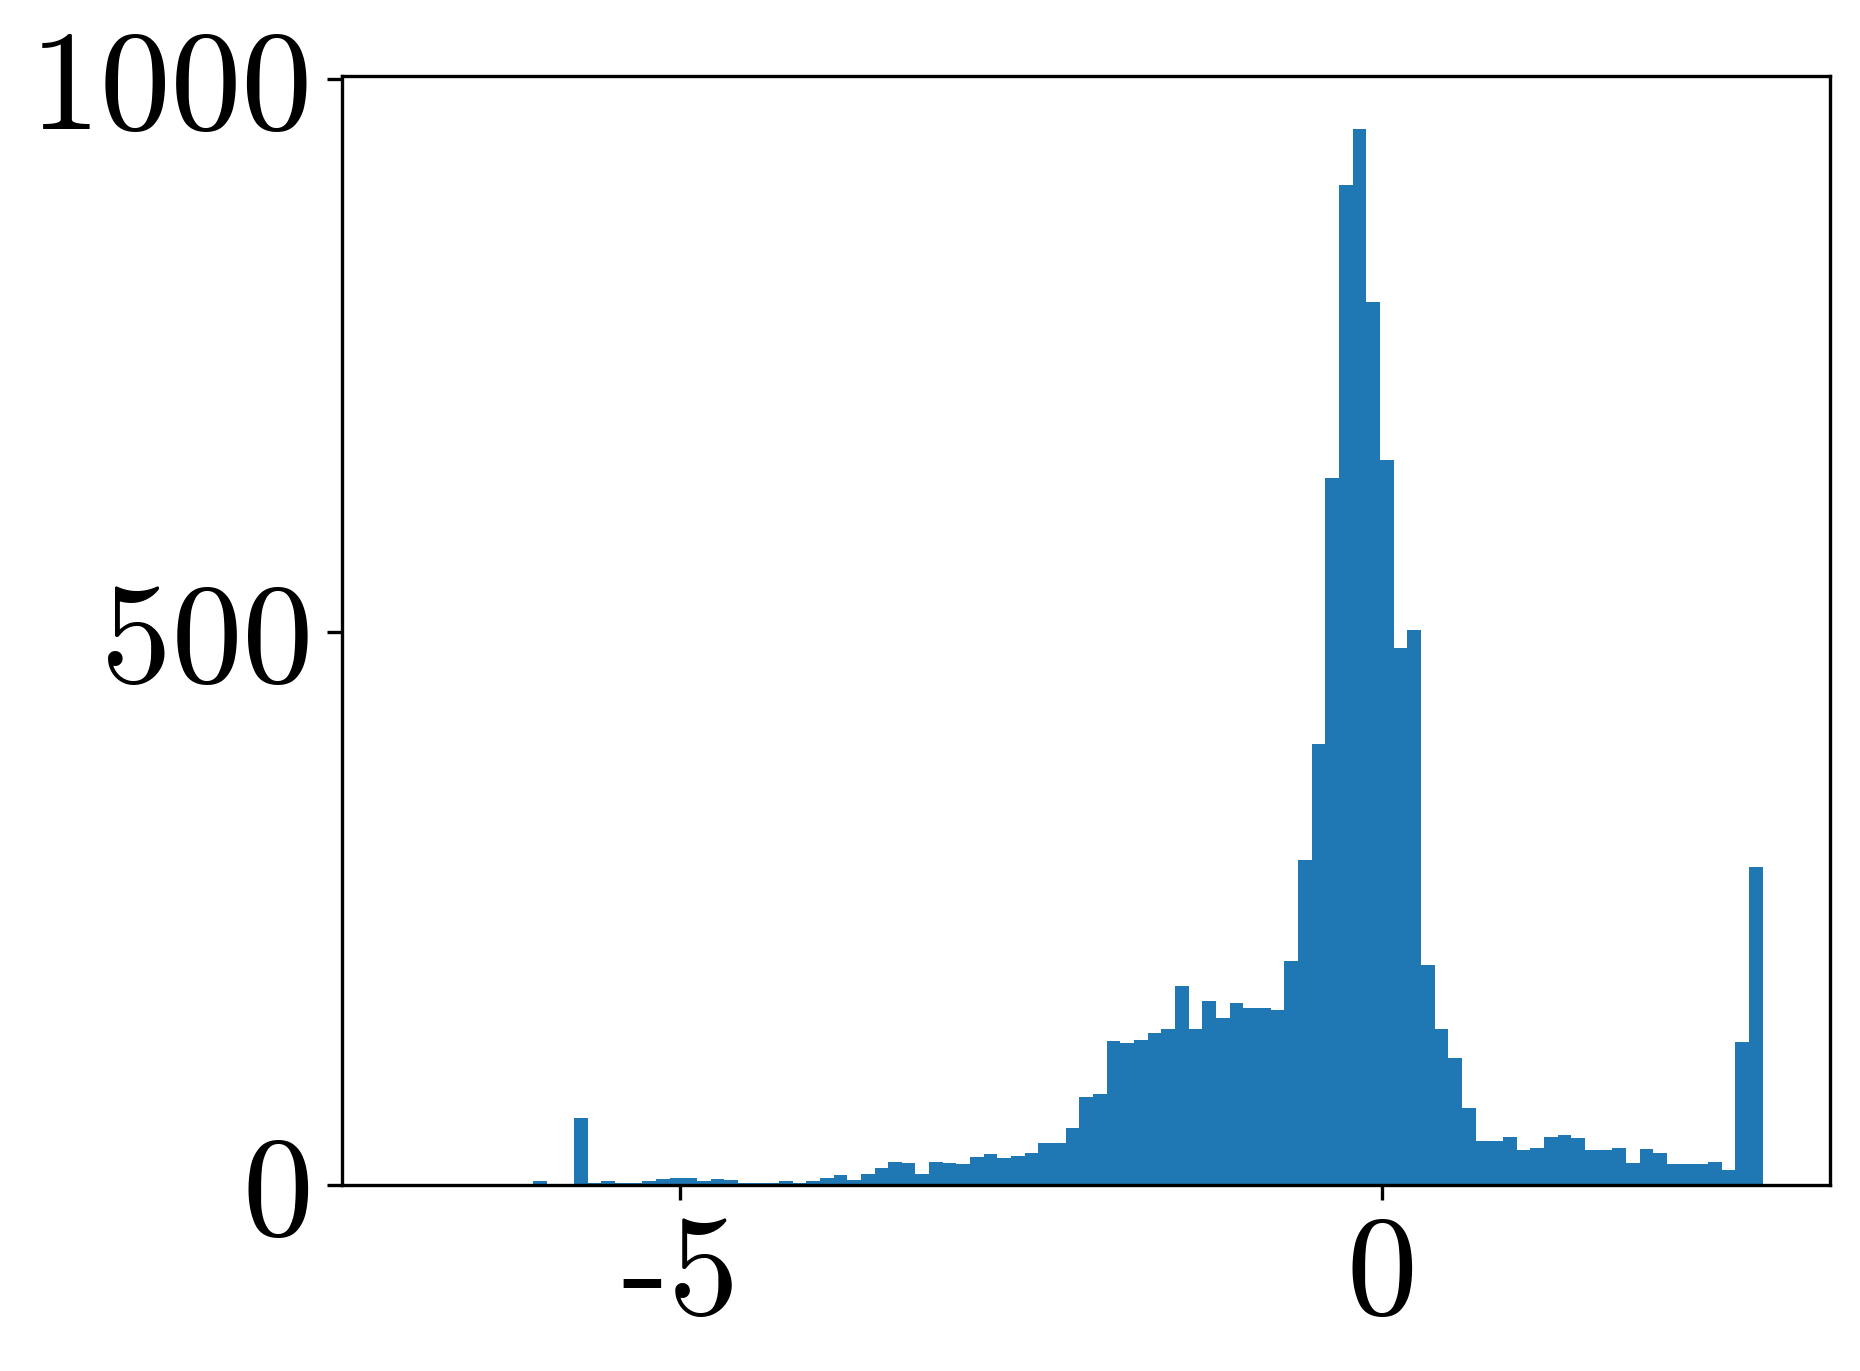

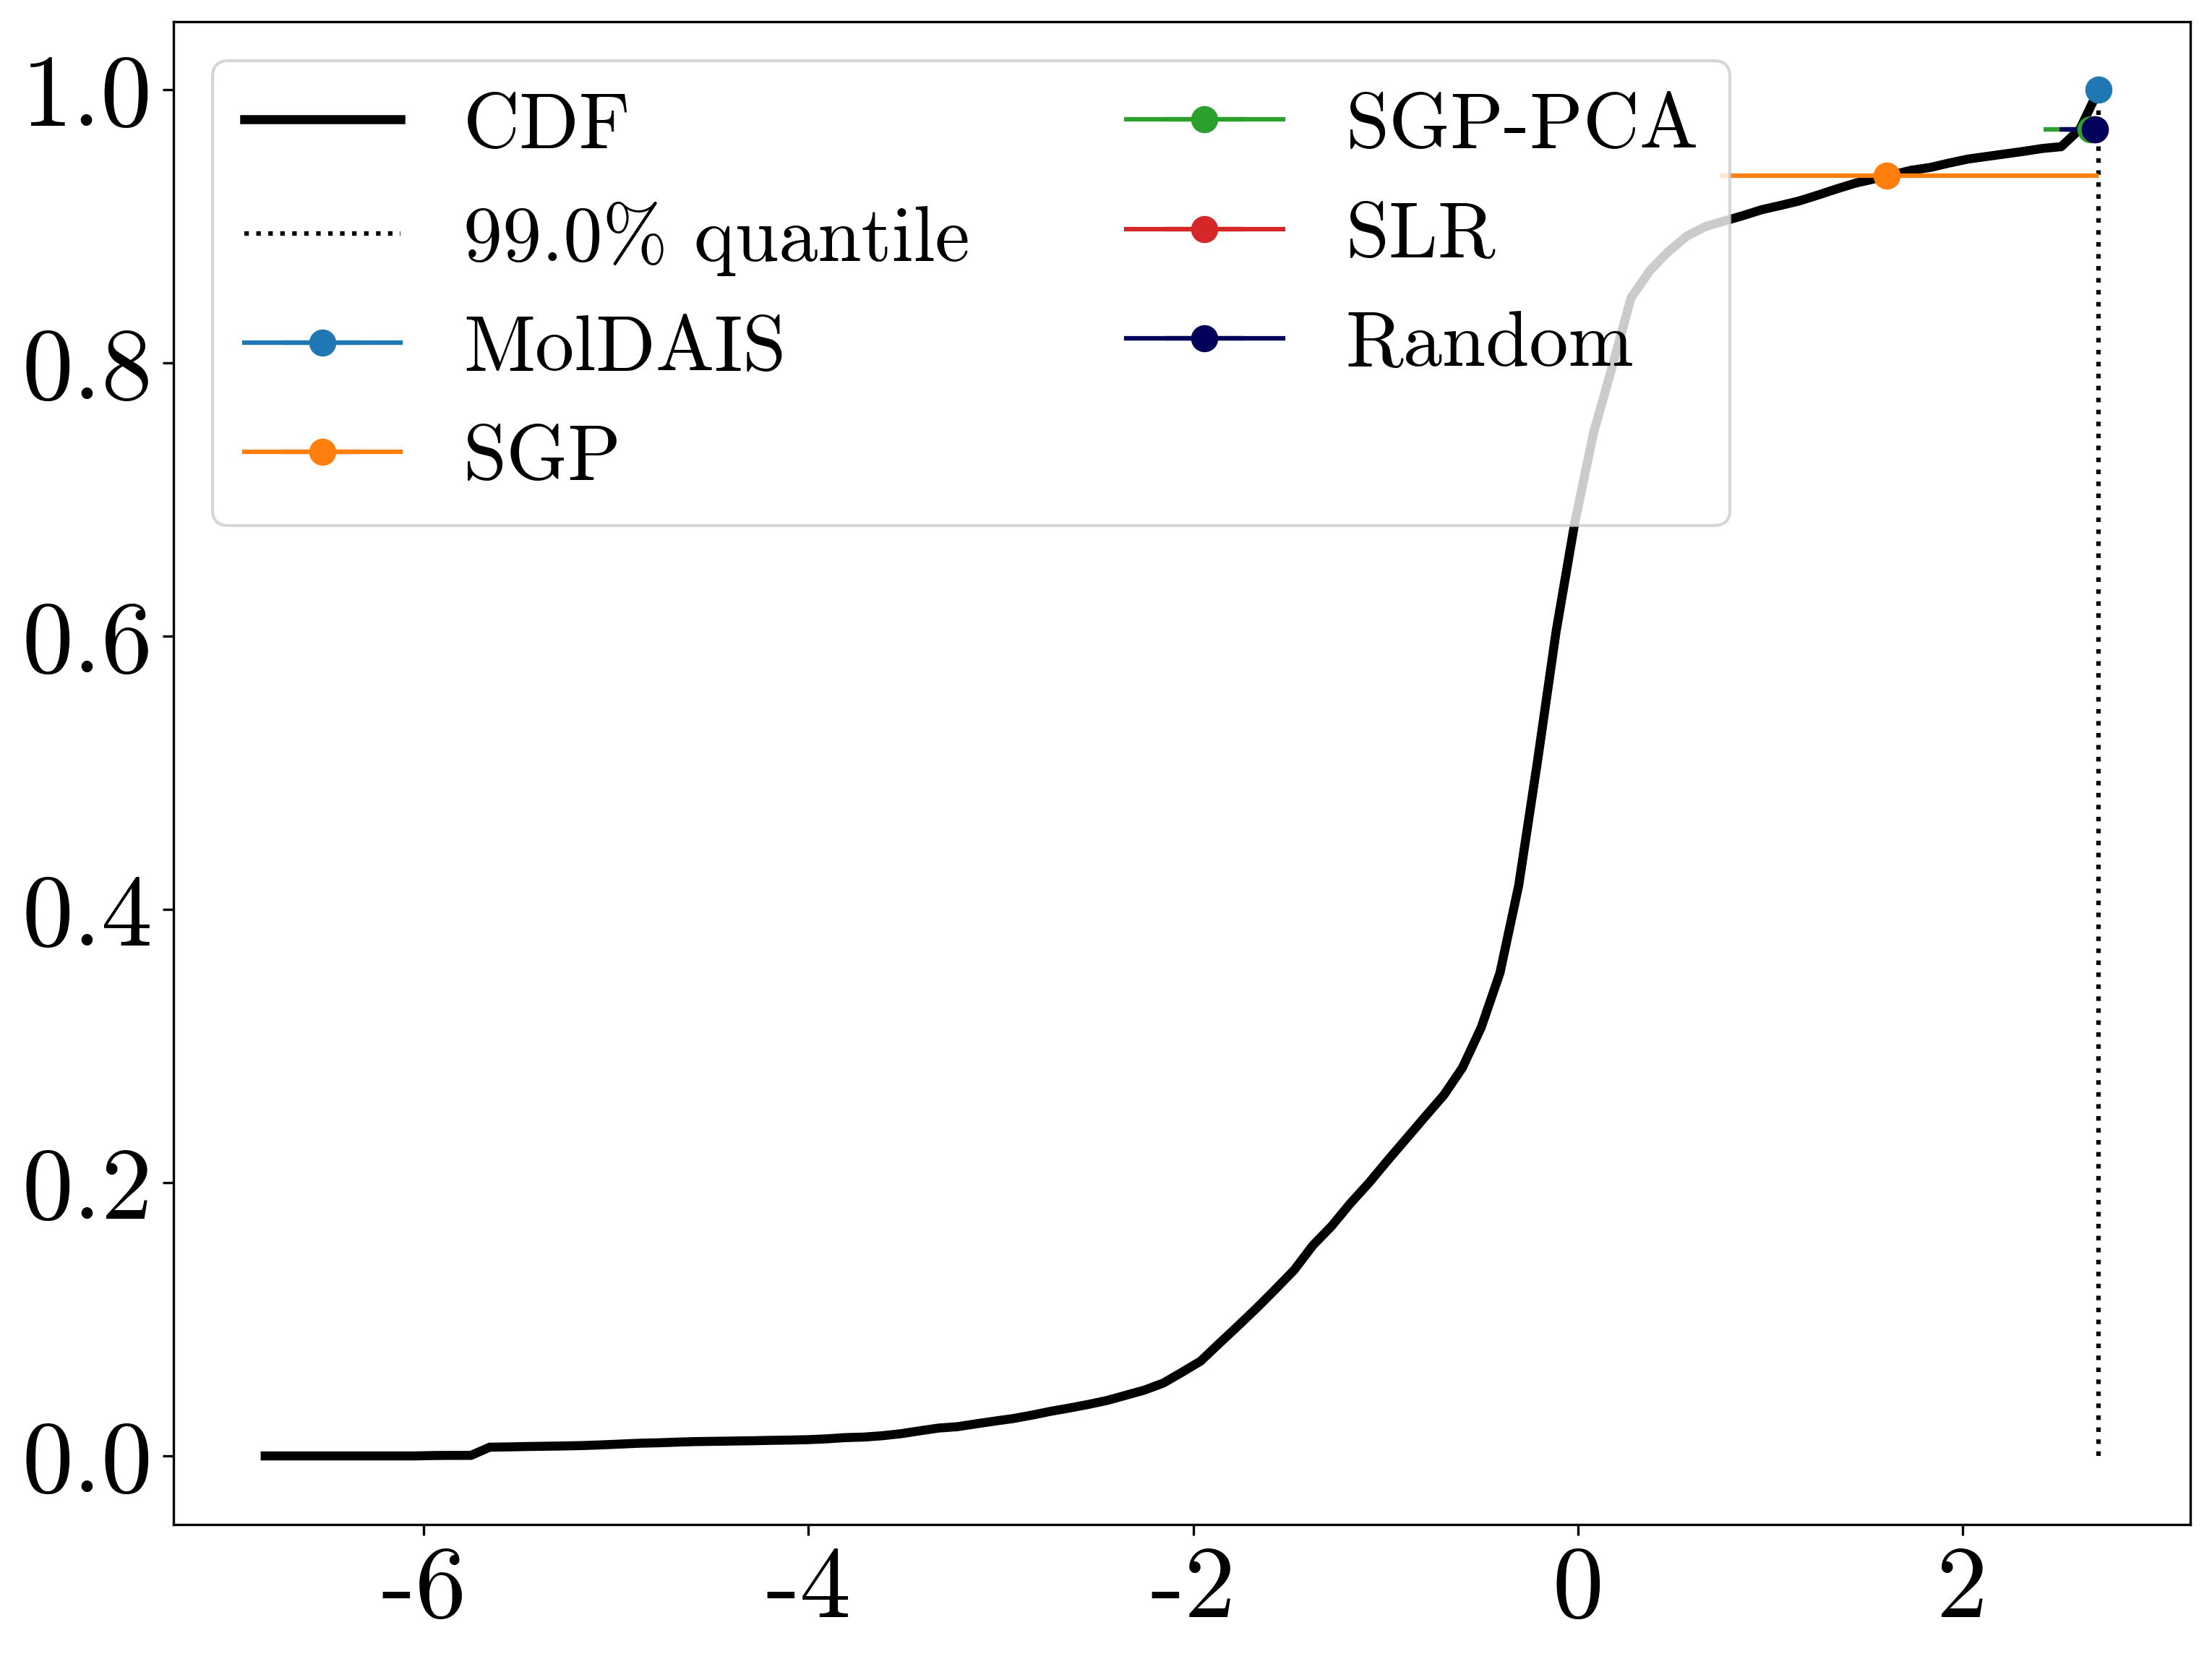

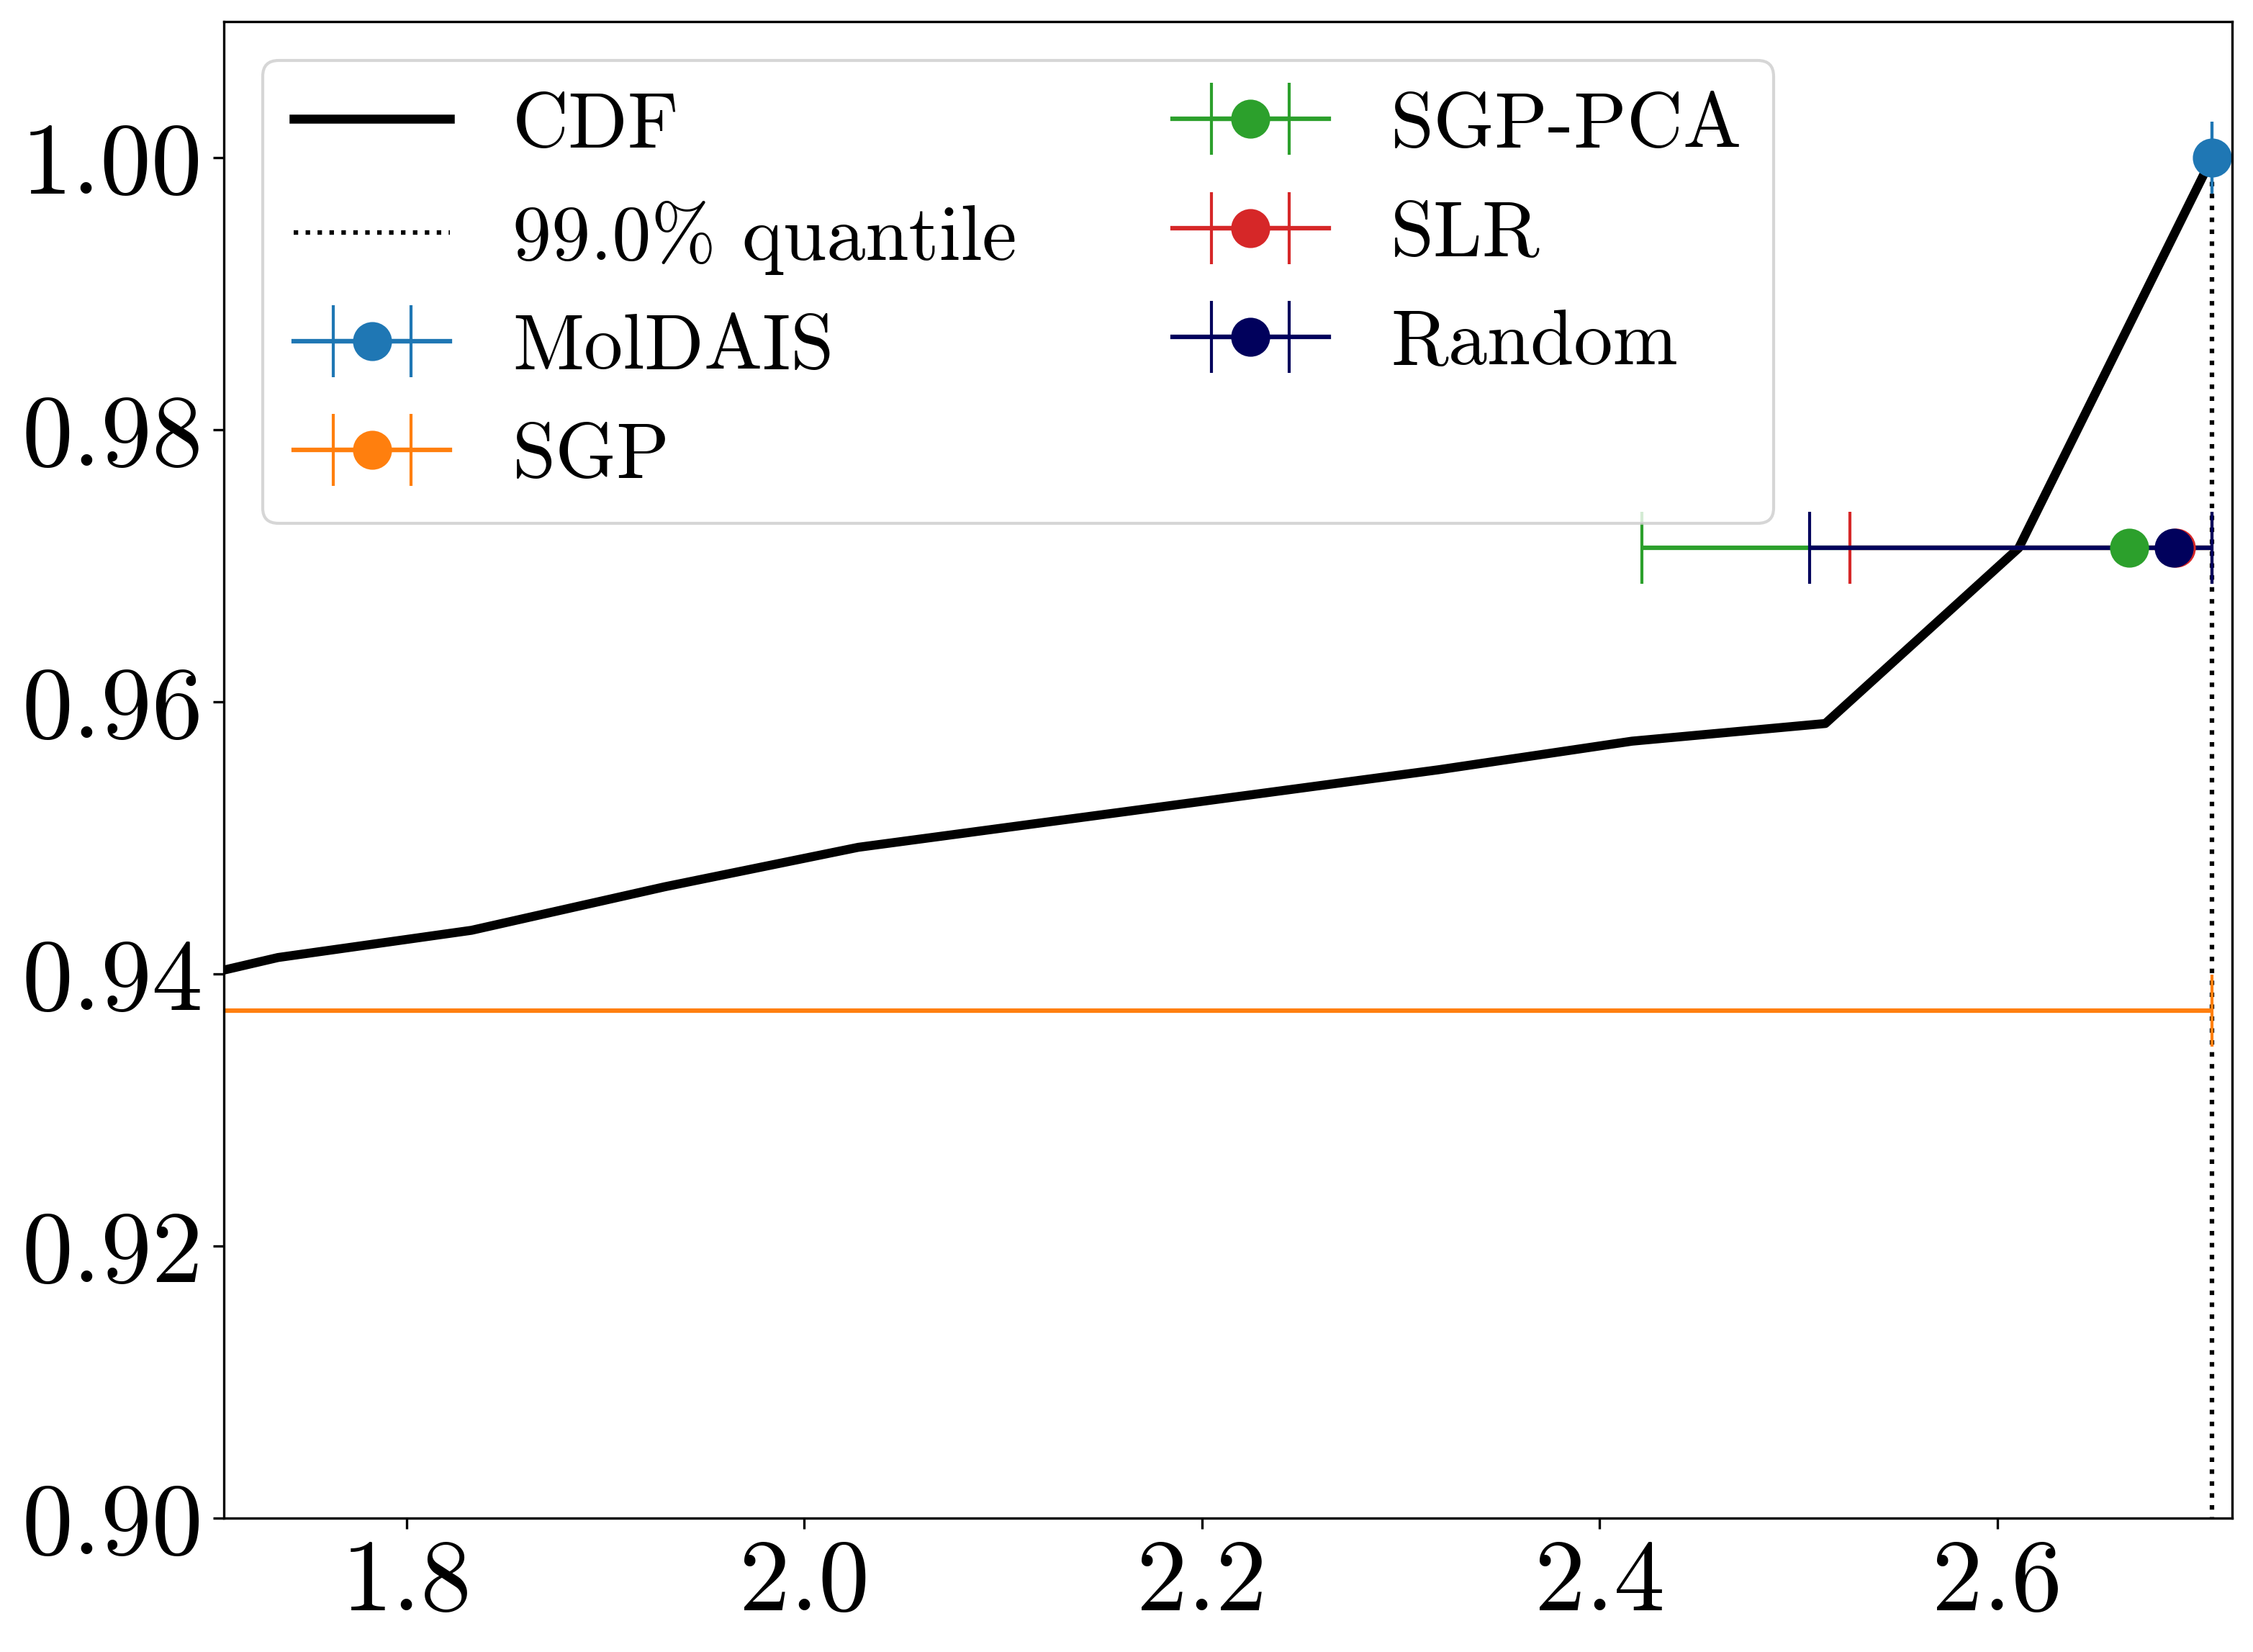

In [321]:
from scipy.stats import percentileofscore

sorted_results = Res_dict_raw['SAAS']
Res_dict_stat['SAAS']
best_found = sorted_results[0,:,-1].max()
worst_found = sorted_results[0,:,-1].min()
mean_found = sorted_results[0,:,-1].mean()

sorted_results = Res_dict_raw['GP_full']
Res_dict_stat['GP_full']
best_found2 = sorted_results[0,:,-1].max()
worst_found2 = sorted_results[0,:,-1].min()
mean_found2 = sorted_results[0,:,-1].mean()


sorted_results = Res_dict_raw['GP_PCA']
Res_dict_stat['GP_PCA']
best_found3 = sorted_results[0,:,-1].max()
worst_found3 = sorted_results[0,:,-1].min()
mean_found3 = sorted_results[0,:,-1].mean()


sorted_results = Res_dict_raw['Linear']
Res_dict_stat['Linear']
best_found4 = sorted_results[0,:,-1].max()
worst_found4 = sorted_results[0,:,-1].min()
mean_found4 = sorted_results[0,:,-1].mean()


sorted_results = Res_dict_raw['random']
Res_dict_stat['random']
best_found5 = sorted_results[0,:,-1].max()
worst_found5 = sorted_results[0,:,-1].min()
mean_found5 = sorted_results[0,:,-1].mean()




df = pd.read_csv('../prop_data/MORDRED_SMILES_Malaria_activity.csv')
dmin, dmax = df['activity'].min(), df['activity'].max()


ms = 8
cs = 8

import matplotlib.patches as patches
inp = torch.tensor(df['activity'].to_numpy())
quantile = .99

act_quant = percentileofscore(df['activity'].to_list(),mean_found)/100
act_quant2 = percentileofscore(df['activity'].to_list(),mean_found2)/100
act_quant3 = percentileofscore(df['activity'].to_list(),mean_found3)/100
act_quant4 = percentileofscore(df['activity'].to_list(),mean_found4)/100
act_quant5 = percentileofscore(df['activity'].to_list(),mean_found5)/100

hist = plt.hist(df['activity'],bins=int(len(df['activity'])/100));

fig, ax = plt.subplots(figsize=(12,9))
count, bins_count = hist[0], hist[1]
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF", linewidth=3, color='k')
plt.vlines(torch.quantile(inp,quantile) , 0,1, color='k', linestyle=':', label= f'{quantile*100:.1f}% quantile')
plt.errorbar([mean_found], [act_quant],   xerr=np.array([[mean_found-worst_found,best_found-mean_found]]).reshape(2,1),      color=colors[0], marker='o', label= names2[0], markersize=ms)
plt.errorbar([mean_found2], [act_quant2], xerr=np.array([[mean_found2-worst_found2,best_found2-mean_found2]]).reshape(2,1),  color=colors[1], marker='o', label= names2[1], markersize=ms)
plt.errorbar([mean_found3], [act_quant3], xerr=np.array([[mean_found3-worst_found3,best_found3-mean_found3]]).reshape(2,1),  color=colors[2], marker='o', label= names2[2], markersize=ms)
plt.errorbar([mean_found4], [act_quant4], xerr=np.array([[mean_found4-worst_found4,best_found4-mean_found4]]).reshape(2,1),  color=colors[3], marker='o', label= names2[3], markersize=ms)
plt.errorbar([mean_found5], [act_quant5], xerr=np.array([[mean_found5-worst_found5,best_found5-mean_found5]]).reshape(2,1),  color=colors[4], marker='o', label= names2[4], markersize=ms)
plt.legend(ncols=2, fontsize=26, loc = 2)
plt.savefig('./figs/malaria/CDF_quantiles.png')



ms = 12
cs = 12


fig, ax = plt.subplots(figsize=(12,9))
count, bins_count = hist[0], hist[1]
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF", linewidth=3, color='k')
plt.vlines(torch.quantile(inp,quantile) , 0,1, color='k', linestyle=':', label= f'{quantile*100:.1f}% quantile')
plt.errorbar([mean_found], [act_quant],   xerr=np.array([[mean_found-worst_found,best_found-mean_found]]).reshape(2,1),      color=colors[0], marker='o', label= names2[0], markersize=ms, capsize=cs)
plt.errorbar([mean_found2], [act_quant2], xerr=np.array([[mean_found2-worst_found2,best_found2-mean_found2]]).reshape(2,1),  color=colors[1], marker='o', label= names2[1], markersize=ms, capsize=cs)
plt.errorbar([mean_found3], [act_quant3], xerr=np.array([[mean_found3-worst_found3,best_found3-mean_found3]]).reshape(2,1),  color=colors[2], marker='o', label= names2[2], markersize=ms, capsize=cs)
plt.errorbar([mean_found4], [act_quant4], xerr=np.array([[mean_found4-worst_found4,best_found4-mean_found4]]).reshape(2,1),  color=colors[3], marker='o', label= names2[3], markersize=ms, capsize=cs)
plt.errorbar([mean_found5], [act_quant5], xerr=np.array([[mean_found5-worst_found5,best_found5-mean_found5]]).reshape(2,1),  color=colors[4], marker='o', label= names2[4], markersize=ms, capsize=cs)
plt.legend(ncols=2, fontsize=26)
#plt.xscale("log")
plt.xlim(dmax-1, dmax+.01)
plt.ylim(.9,1.01)
plt.savefig('./figs/malaria/CDF_quantiles_zoom.png')


/tmp/ipykernel_4121106/3283889447.py:24: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  hist = plt.hist(df['activity'],bins=int(len(df['activity'])))
/tmp/ipykernel_4121106/3283889447.py:29: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,9))
/tmp/ipykernel_4121106/3283889447.py:38: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,9))
/tmp/ipykernel_4121106/3283889447.py:51: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,9))


(0.5, 2.80805020110221)

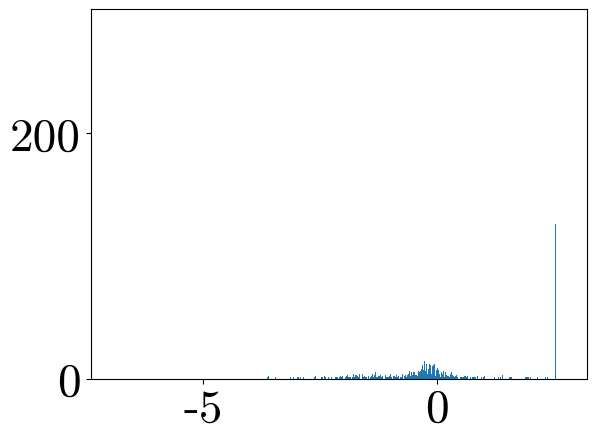

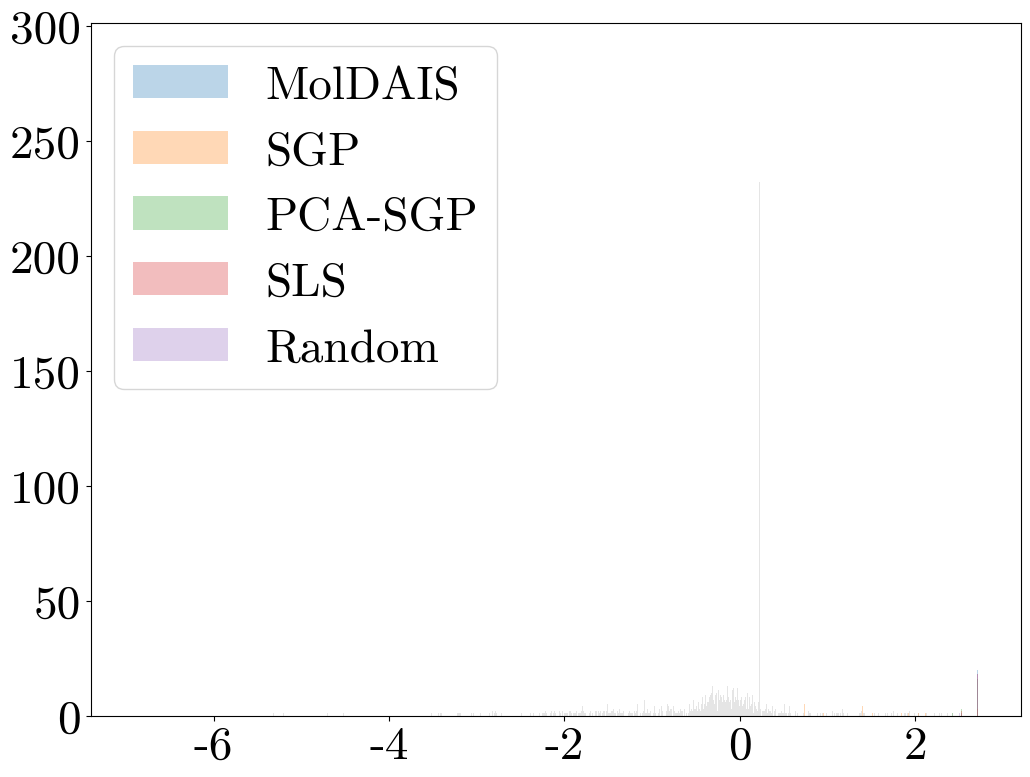

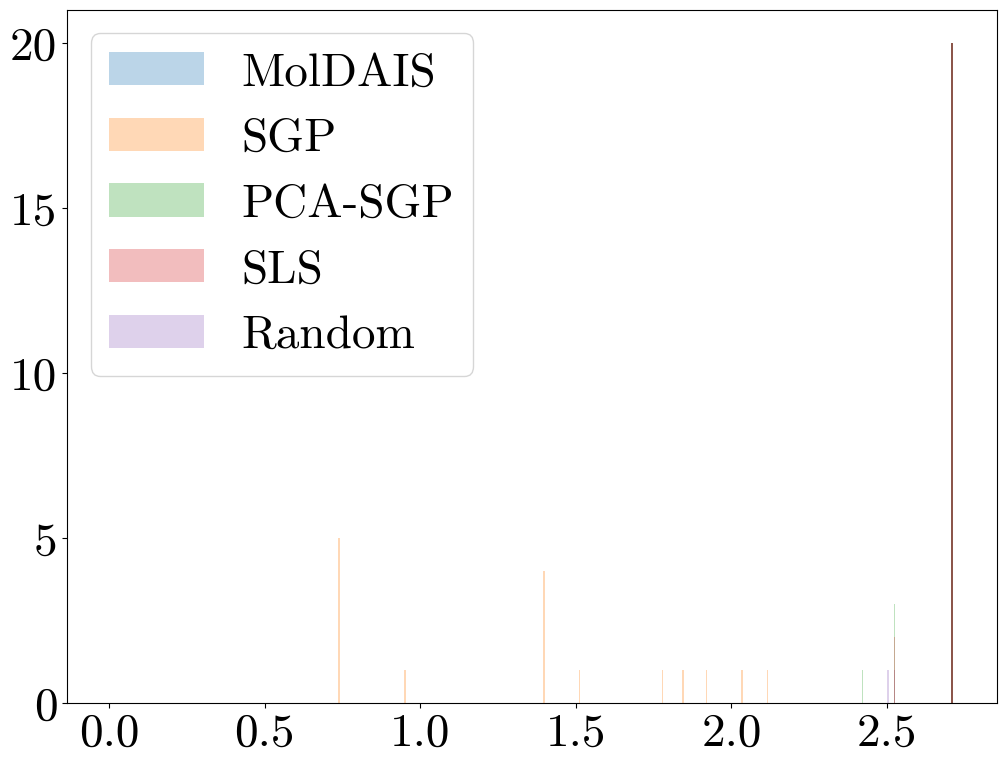

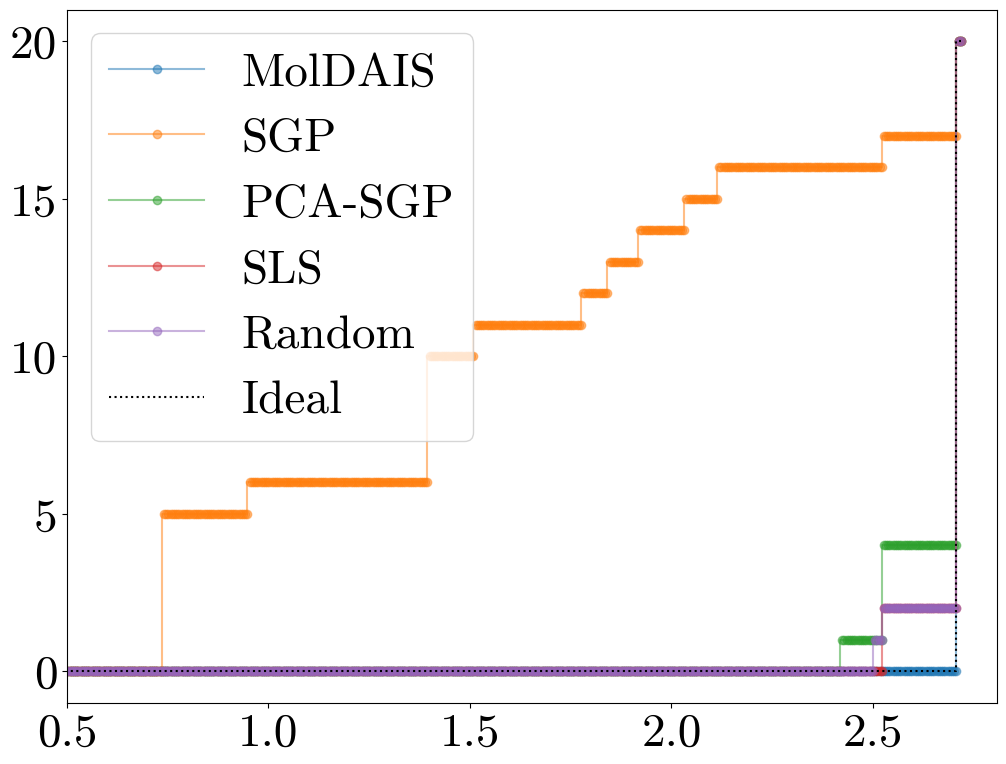

In [273]:


sorted_results = Res_dict_raw['SAAS']
Res_dict_stat['SAAS']
best_found = sorted_results[0,:,end]

sorted_results = Res_dict_raw['GP_full']
Res_dict_stat['GP_full']
best_found2 = sorted_results[0,:,end]

sorted_results = Res_dict_raw['GP_PCA']
Res_dict_stat['GP_PCA']
best_found3 = sorted_results[0,:,end]

sorted_results = Res_dict_raw['Linear']
Res_dict_stat['Linear']
best_found4 = sorted_results[0,:,end]

sorted_results = Res_dict_raw['random']
Res_dict_stat['random']
best_found5 = sorted_results[0,:,end]



count, bins_count = hist[0], hist[1]
hist = plt.hist(df['activity'],bins=int(len(df['activity'])))


bins = np.linspace(0,dmax+.01,500)

fig, ax = plt.subplots(figsize=(12,9))
plt.hist(best_found,bins=bins, alpha=.3,label='MolDAIS')
plt.hist(best_found2,bins=bins,alpha=.3,label='SGP')
plt.hist(best_found3,bins=bins,alpha=.3,label='PCA-SGP')
plt.hist(best_found4,bins=bins,alpha=.3,label='SLS')
plt.hist(best_found5,bins=bins,alpha=.3,label='Random')
plt.hist(df['activity'],bins=bins_count[1:],alpha=.2, color='gray')
plt.legend()

fig, ax = plt.subplots(figsize=(12,9))
hist1 = plt.hist(best_found,bins=bins, alpha=.3,label='MolDAIS')
hist2 = plt.hist(best_found2,bins=bins,alpha=.3,label='SGP')
hist3 = plt.hist(best_found3,bins=bins,alpha=.3,label='PCA-SGP')
hist4 = plt.hist(best_found4,bins=bins,alpha=.3,label='SLS')
hist5 = plt.hist(best_found5,bins=bins,alpha=.3,label='Random')
#plt.hist(df['activity'],bins=bins_count[1:],alpha=.2, color='gray')
plt.legend()
#plt.xlim(0,3)
#plt.ylim(0,len(seeds)+1)

hist6 = plt.hist(best_found5*0+dmax, bins = bins)

fig, ax = plt.subplots(figsize=(12,9))
plt.step(hist1[1][1:],np.cumsum(hist1[0]),marker='o', alpha=.5,label='MolDAIS')
plt.step(hist2[1][1:],np.cumsum(hist2[0]),marker='o', alpha=.5,label='SGP')
plt.step(hist3[1][1:],np.cumsum(hist3[0]),marker='o', alpha=.5,label='PCA-SGP')
plt.step(hist4[1][1:],np.cumsum(hist4[0]),marker='o', alpha=.5,label='SLS')
plt.step(hist5[1][1:],np.cumsum(hist5[0]),marker='o', alpha=.5,label='Random')
plt.step(hist6[1][1:],np.cumsum(hist6[0]), 'k:', alpha=1,label='Ideal')
#plt.hist(df['activity'],bins=bins_count[1:],alpha=.2, color='gray')
plt.legend()
plt.xlim(0.5,dmax+0.1)
#plt.ylim(0,len(seeds)+1)



In [225]:
inp = torch.tensor(df['activity'].to_numpy())
torch.quantile(inp,.995),torch.quantile(inp,.997),torch.quantile(inp,.999) 
best_found

array([2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025,
       2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025,
       2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025,
       2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025])

In [259]:
hist1[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [227]:
worst_found,mean_found , best_found

(2.70805025100708,
 2.70805025100708,
 array([2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025,
        2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025,
        2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025,
        2.70805025, 2.70805025, 2.70805025, 2.70805025, 2.70805025]))

In [228]:
# plot molecule sample sequence
import rdkit as rd
from rdkit.Chem import Draw

bestsmis = df['SMILES'][df['activity']>=2.70805025100708].to_list()


sorted_results1 = Res_dict_raw['SAAS']
sorted_results2 = Res_dict_raw['GP_full']
sorted_results3 = Res_dict_raw['GP_PCA']
sorted_results4 = Res_dict_raw['Linear']

idx = 0




set1 = sorted_results1[0,idx,:]
set2 = sorted_results2[0,idx,:]
set3 = sorted_results3[0,idx,:]
set4 = sorted_results4[0,idx,:]

smis1 = Smi_dict_stat['SAAS'][idx]
smis2 = Smi_dict_stat['GP_full'][idx]
smis3 = Smi_dict_stat['GP_PCA'][idx]
smis4 = Smi_dict_stat['Linear'][idx]


smi1 = []
smi2 = []
smi3 = []
smi4 = []
m1, m2, m3, m4 = set1[0],  set2[0], set3[0], set4[0]

idx_list1 = []
idx_list2 = []
idx_list3 = []
idx_list4 = []

for i in sample_numbers[1:]:
    
    i1 = set1[:i].max()
    i2 = set2[:i].max()
    i3 = set3[:i].max()
    i4 = set4[:i].max()

    
    if i1>m1 or smis1[i] in bestsmis:
        smi1.append(rd.Chem.MolFromSmiles(smis1[i]))
        m1 = i1
        idx_list1.append([i, i1])
        
    if i2>m2 or smis2[i] in bestsmis:
        smi2.append(rd.Chem.MolFromSmiles(smis2[i]))
        m2 = i2
        idx_list2.append([i,i2])        
        
    if i3>m3 or smis3[i] in bestsmis:
        smi3.append(rd.Chem.MolFromSmiles(smis3[i]))
        m3 = i3
        idx_list3.append([i,i3])        
            
    if i4>m4 or smis4[i] in bestsmis:
        smi4.append(rd.Chem.MolFromSmiles(smis4[i]))
        m4 = i4
        idx_list4.append([i,i4])      


In [308]:

legend=['Itr: '+ str(x[0])+'  =  '+f" {x[1]:.3f}" for x in idx_list1]
print("MolDAIS")
img = rd.Chem.Draw.MolsToGridImage(smi1,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)


png = img.data
with open('./figs/malaria/mols_SAAS.png','wb+') as outf:
    outf.write(png)

MolDAIS


In [309]:
legend=['Itr: '+ str(x[0])+'  =  '+f" {x[1]:.3f}" for x in idx_list2]
print("SBO")
img = rd.Chem.Draw.MolsToGridImage(smi2,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)


png = img.data
with open('./figs/malaria/mols_SBO.png','wb+') as outf:
    outf.write(png)

SBO


In [310]:
legend=['Itr: '+ str(x[0])+'  =  '+f" {x[1]:.3f}" for x in idx_list3]
print('SBO-PCA')
img = rd.Chem.Draw.MolsToGridImage(smi3,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)

png = img.data
with open('./figs/malaria/mols_SBOPCA.png','wb+') as outf:
    outf.write(png)

SBO-PCA


In [311]:
legend=['Itr: '+ str(x[0])+'  =  '+f" {x[1]:.3f}" for x in idx_list4]
print('SLR')
img = rd.Chem.Draw.MolsToGridImage(smi4,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)

png = img.data
with open('./figs/malaria/mols_SLR.png','wb+') as outf:
    outf.write(png)

SLR


In [312]:
dmax, dmin = df['activity'].max(), df['activity'].min()

287


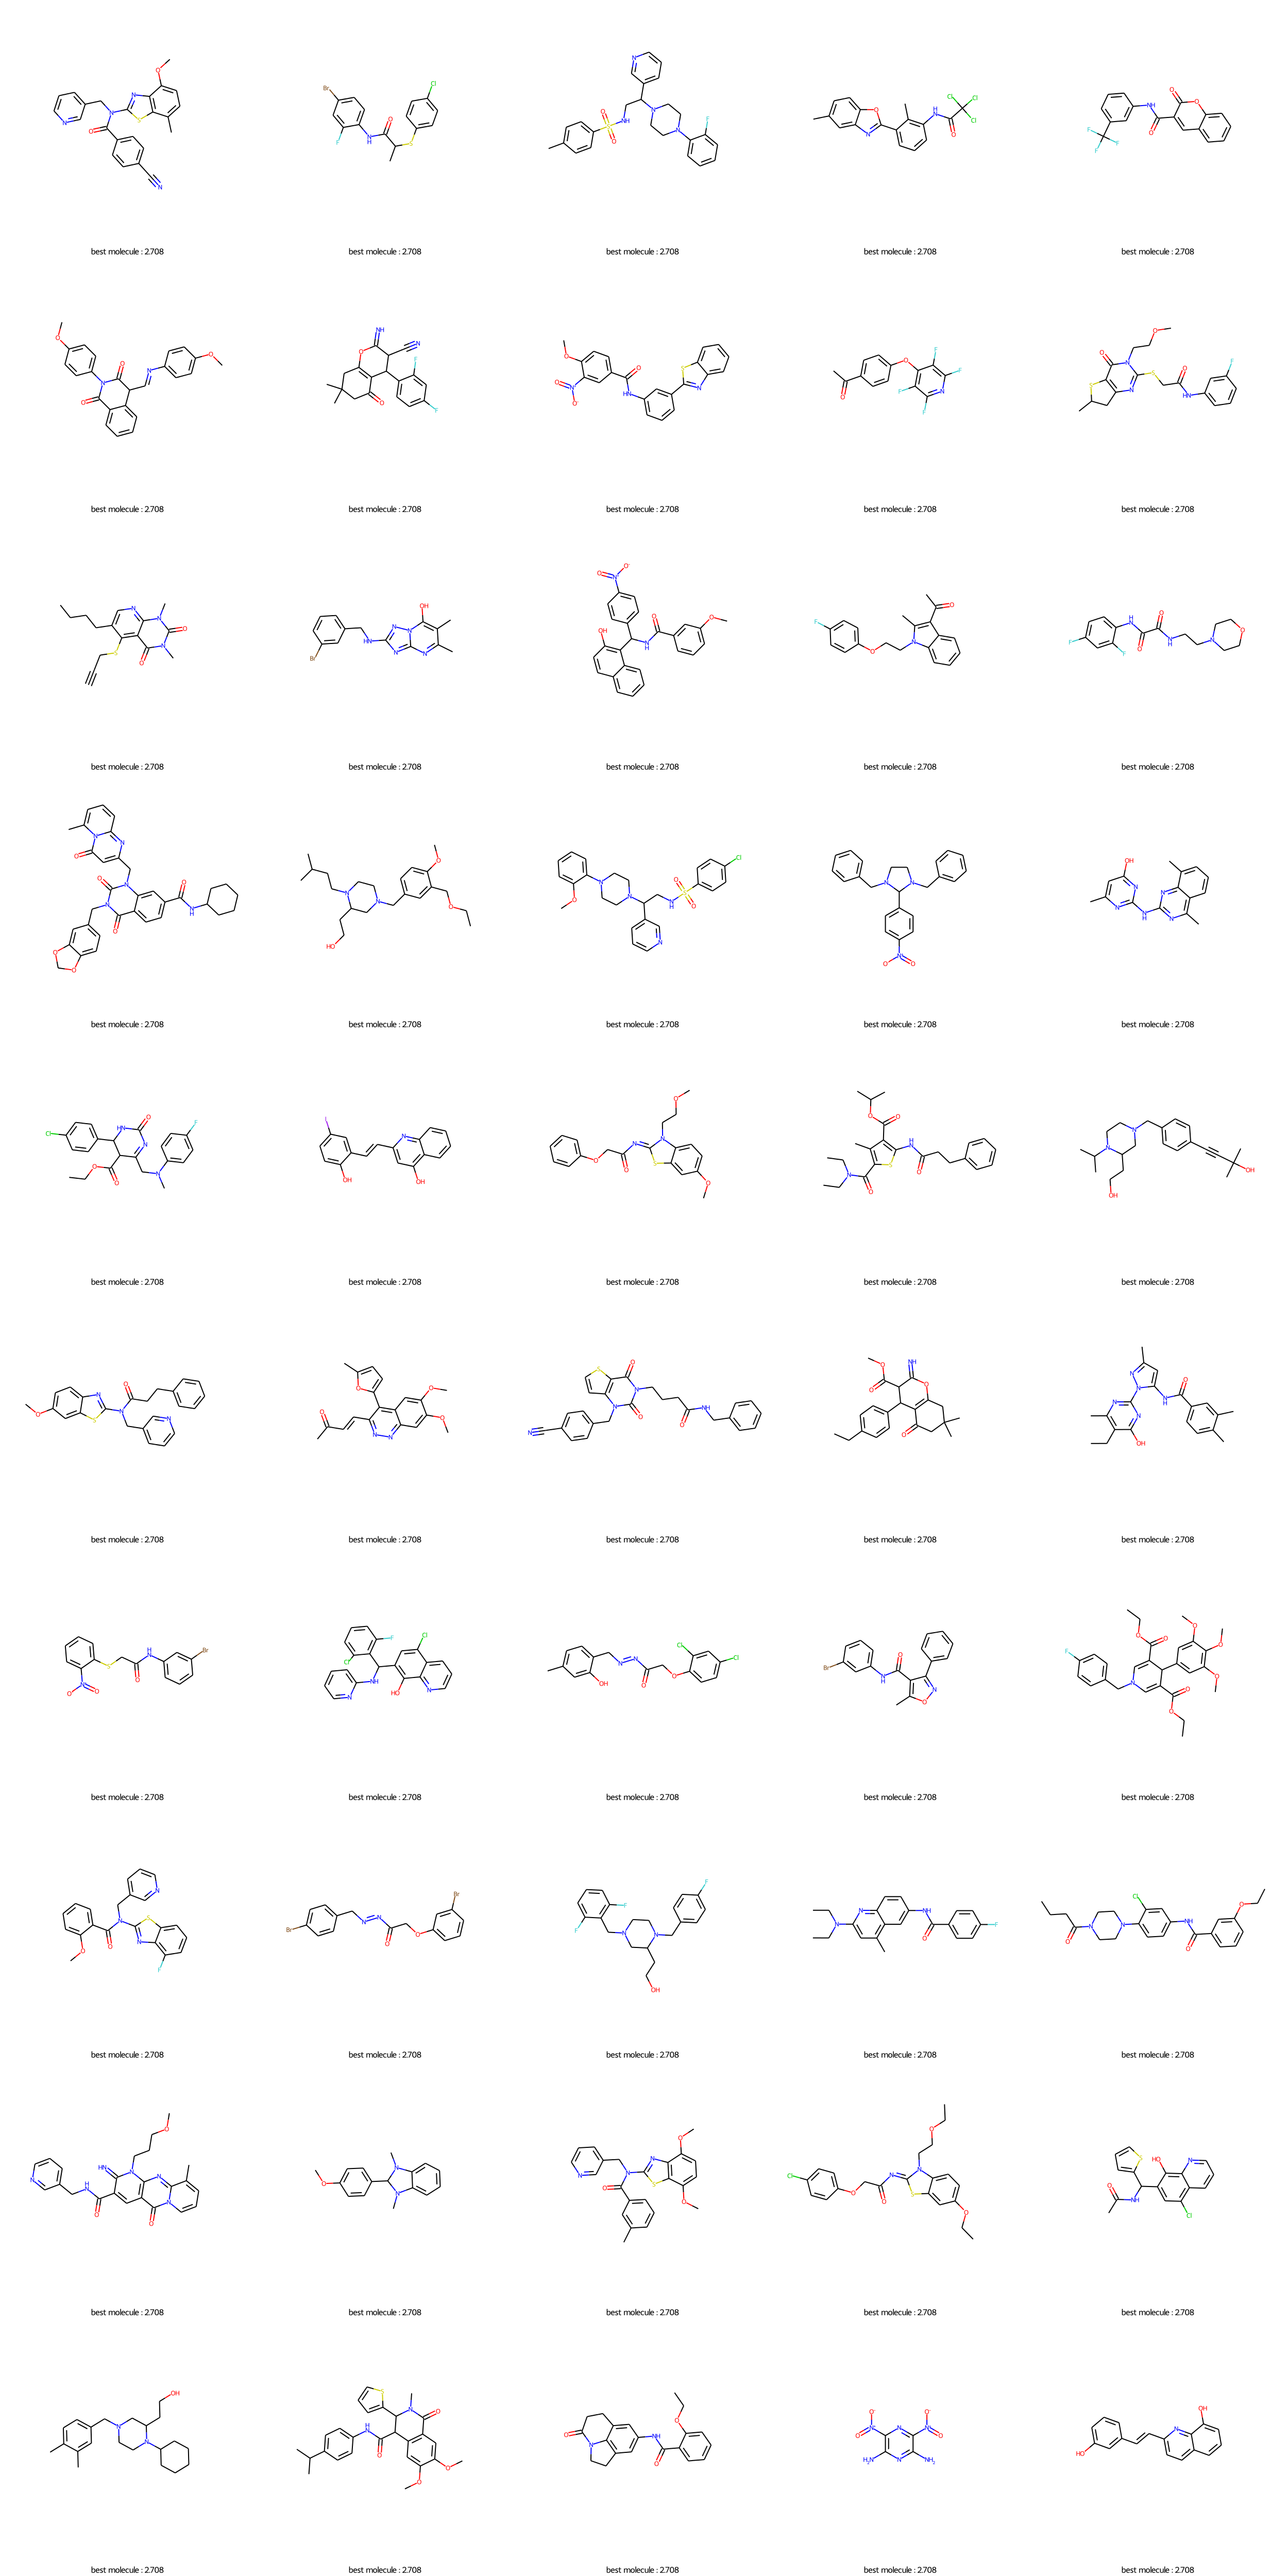

In [313]:
bestsmis = df['SMILES'][df['activity']>=dmax].to_list()
bestmol=[]
for i in bestsmis: 
    bestmol.append(rd.Chem.MolFromSmiles( i))
bestval =  df['activity'][df['activity']>=dmax].to_list()
legend = [f"best molecule : {bestval[i]:.3f}" for i in range(len(bestval))]
print(len(bestval))
img = rd.Chem.Draw.MolsToGridImage(bestmol,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)

png = img.data
with open('./figs/malaria/mols_best.png','wb+') as outf:
    outf.write(png)
    
rd.Chem.Draw.MolsToGridImage(bestmol,molsPerRow=5,subImgSize=(500,500),useSVG=False,legends=legend)

In [235]:
legend

['best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molecule : 2.708',
 'best molec

In [236]:

rr1= []
for k,i in enumerate(smis1):
    if i in  df['SMILES'].to_list():
        rr1.append(df[df['SMILES']==i]['activity'].item())
        
rr2= []
for k,i in enumerate(smis2):
    if i in  df['SMILES'].to_list():
        rr2.append(df[df['SMILES']==i]['activity'].item())
        
rr4= []
for k,i in enumerate(smis4):
    if i in  df['SMILES'].to_list():
        rr4.append(df[df['SMILES']==i]['activity'].item())
        
rr3= []
for k,i in enumerate(smis3):
    if i in  df['SMILES'].to_list():
        rr3.append(df[df['SMILES']==i]['activity'].item())
        
        
print(np.array(rr1).max())
print(np.array(rr2).max())
print(np.array(rr4).max())
print(np.array(rr3).max())

2.70805020110221
0.738598443463863
2.70805020110221
2.42125662271154


In [237]:
dmin = np.array(df['activity'].to_list()).min()#[df['activity']>=11.]
dmax = np.array(df['activity'].to_list()).max()#[df['activity']>=11.]
dmax,dmin

(2.70805020110221, -6.92185420336164)

In [238]:
print(sorted_results1[0,:,-1])
print(sorted_results2[0,:,-1])
print(sorted_results3[0,:,-1])
print(sorted_results4[0,:,-1])
sorted_results1.shape

[2.70805025 2.70805025 2.70805025 2.70805025 2.70805025 2.70805025
 2.70805025 2.70805025 2.70805025 2.70805025 2.70805025 2.70805025
 2.70805025 2.70805025 2.70805025 2.70805025 2.70805025 2.70805025
 2.70805025 2.70805025]
[0.73859847 1.92038715 2.03321433 2.5257287  1.39871693 2.70805025
 0.73859847 1.39871693 1.51012576 1.8453002  0.95088536 2.70805025
 1.39871693 0.73859847 2.11745954 1.39871693 1.77640891 0.73859847
 2.70805025 0.73859847]
[2.42125654 2.70805025 2.70805025 2.70805025 2.70805025 2.70805025
 2.70805025 2.70805025 2.70805025 2.70805025 2.70805025 2.5257287
 2.5257287  2.70805025 2.70805025 2.70805025 2.70805025 2.70805025
 2.70805025 2.5257287 ]
[2.70805025 2.70805025 2.70805025 2.5257287  2.70805025 2.70805025
 2.5257287  2.70805025 2.70805025 2.70805025 2.70805025 2.70805025
 2.70805025 2.70805025 2.70805025 2.70805025 2.70805025 2.70805025
 2.70805025 2.70805025]


(1, 20, 91)

/tmp/ipykernel_4121106/3232762401.py:38: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.axvline(i, color=C[i], linestyle='-', zorder=0)
/tmp/ipykernel_4121106/3232762401.py:50: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.axvline(i, color=C[i], linestyle='-', zorder=0)


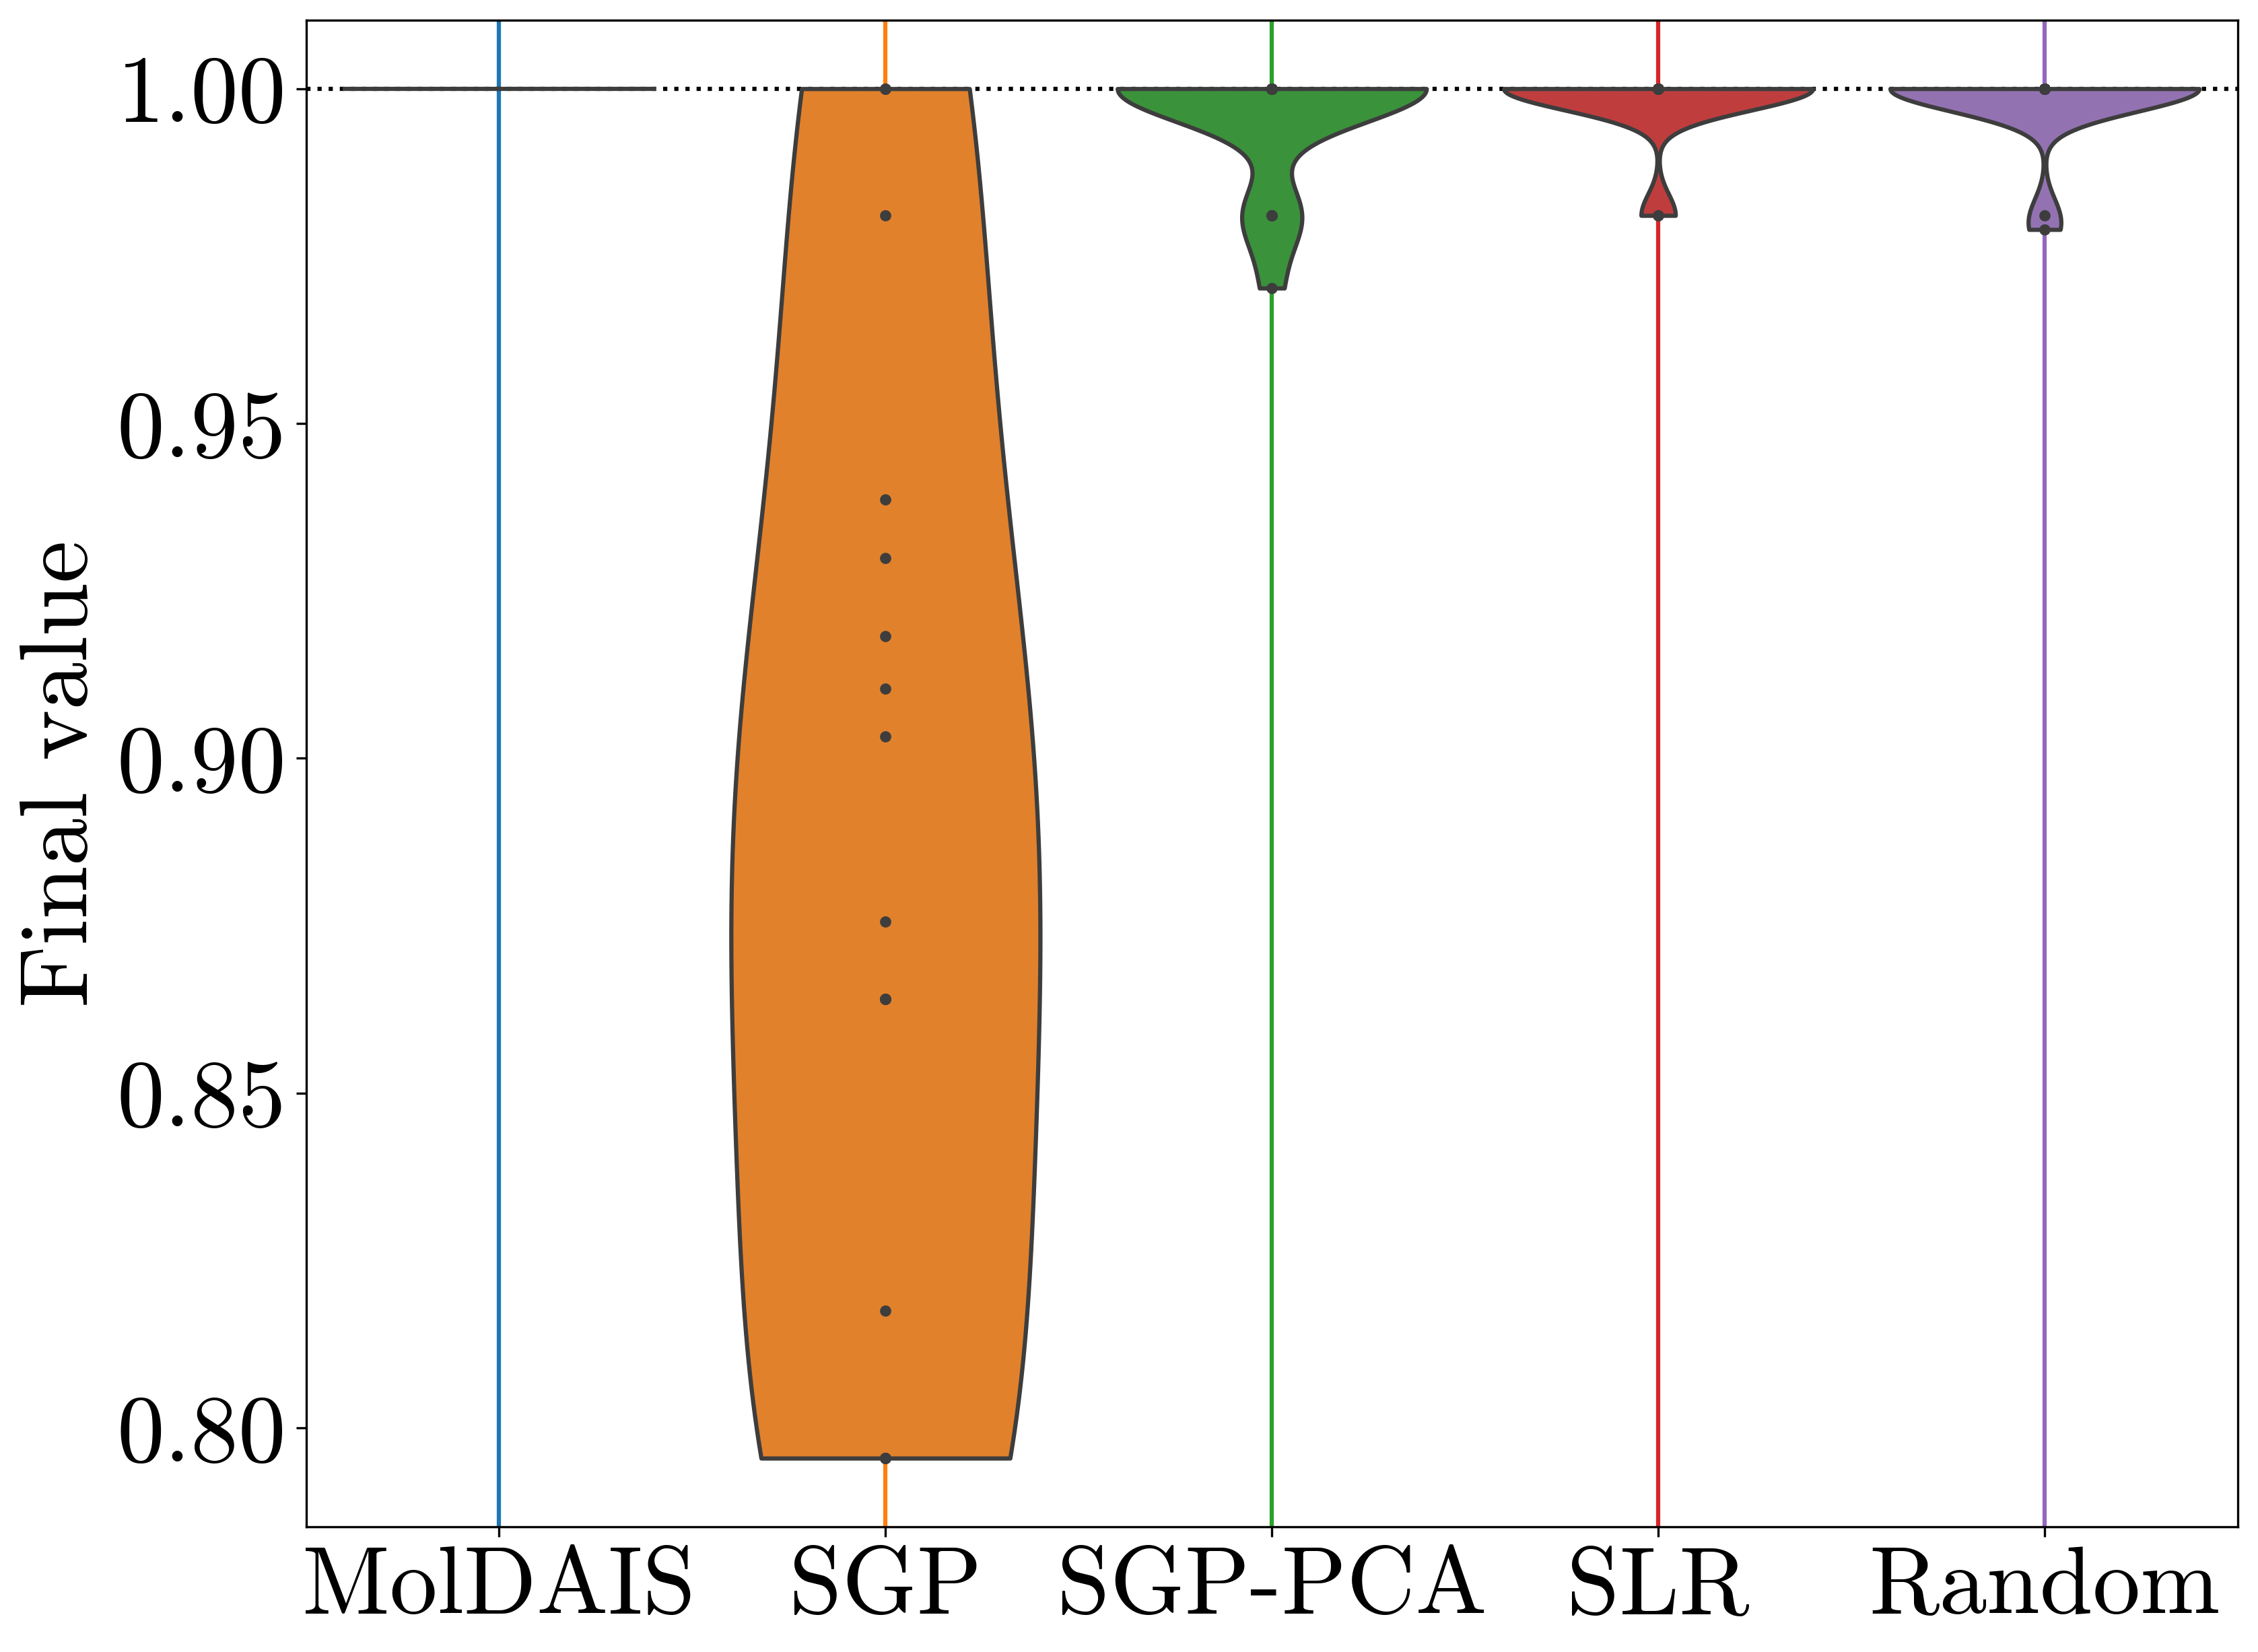

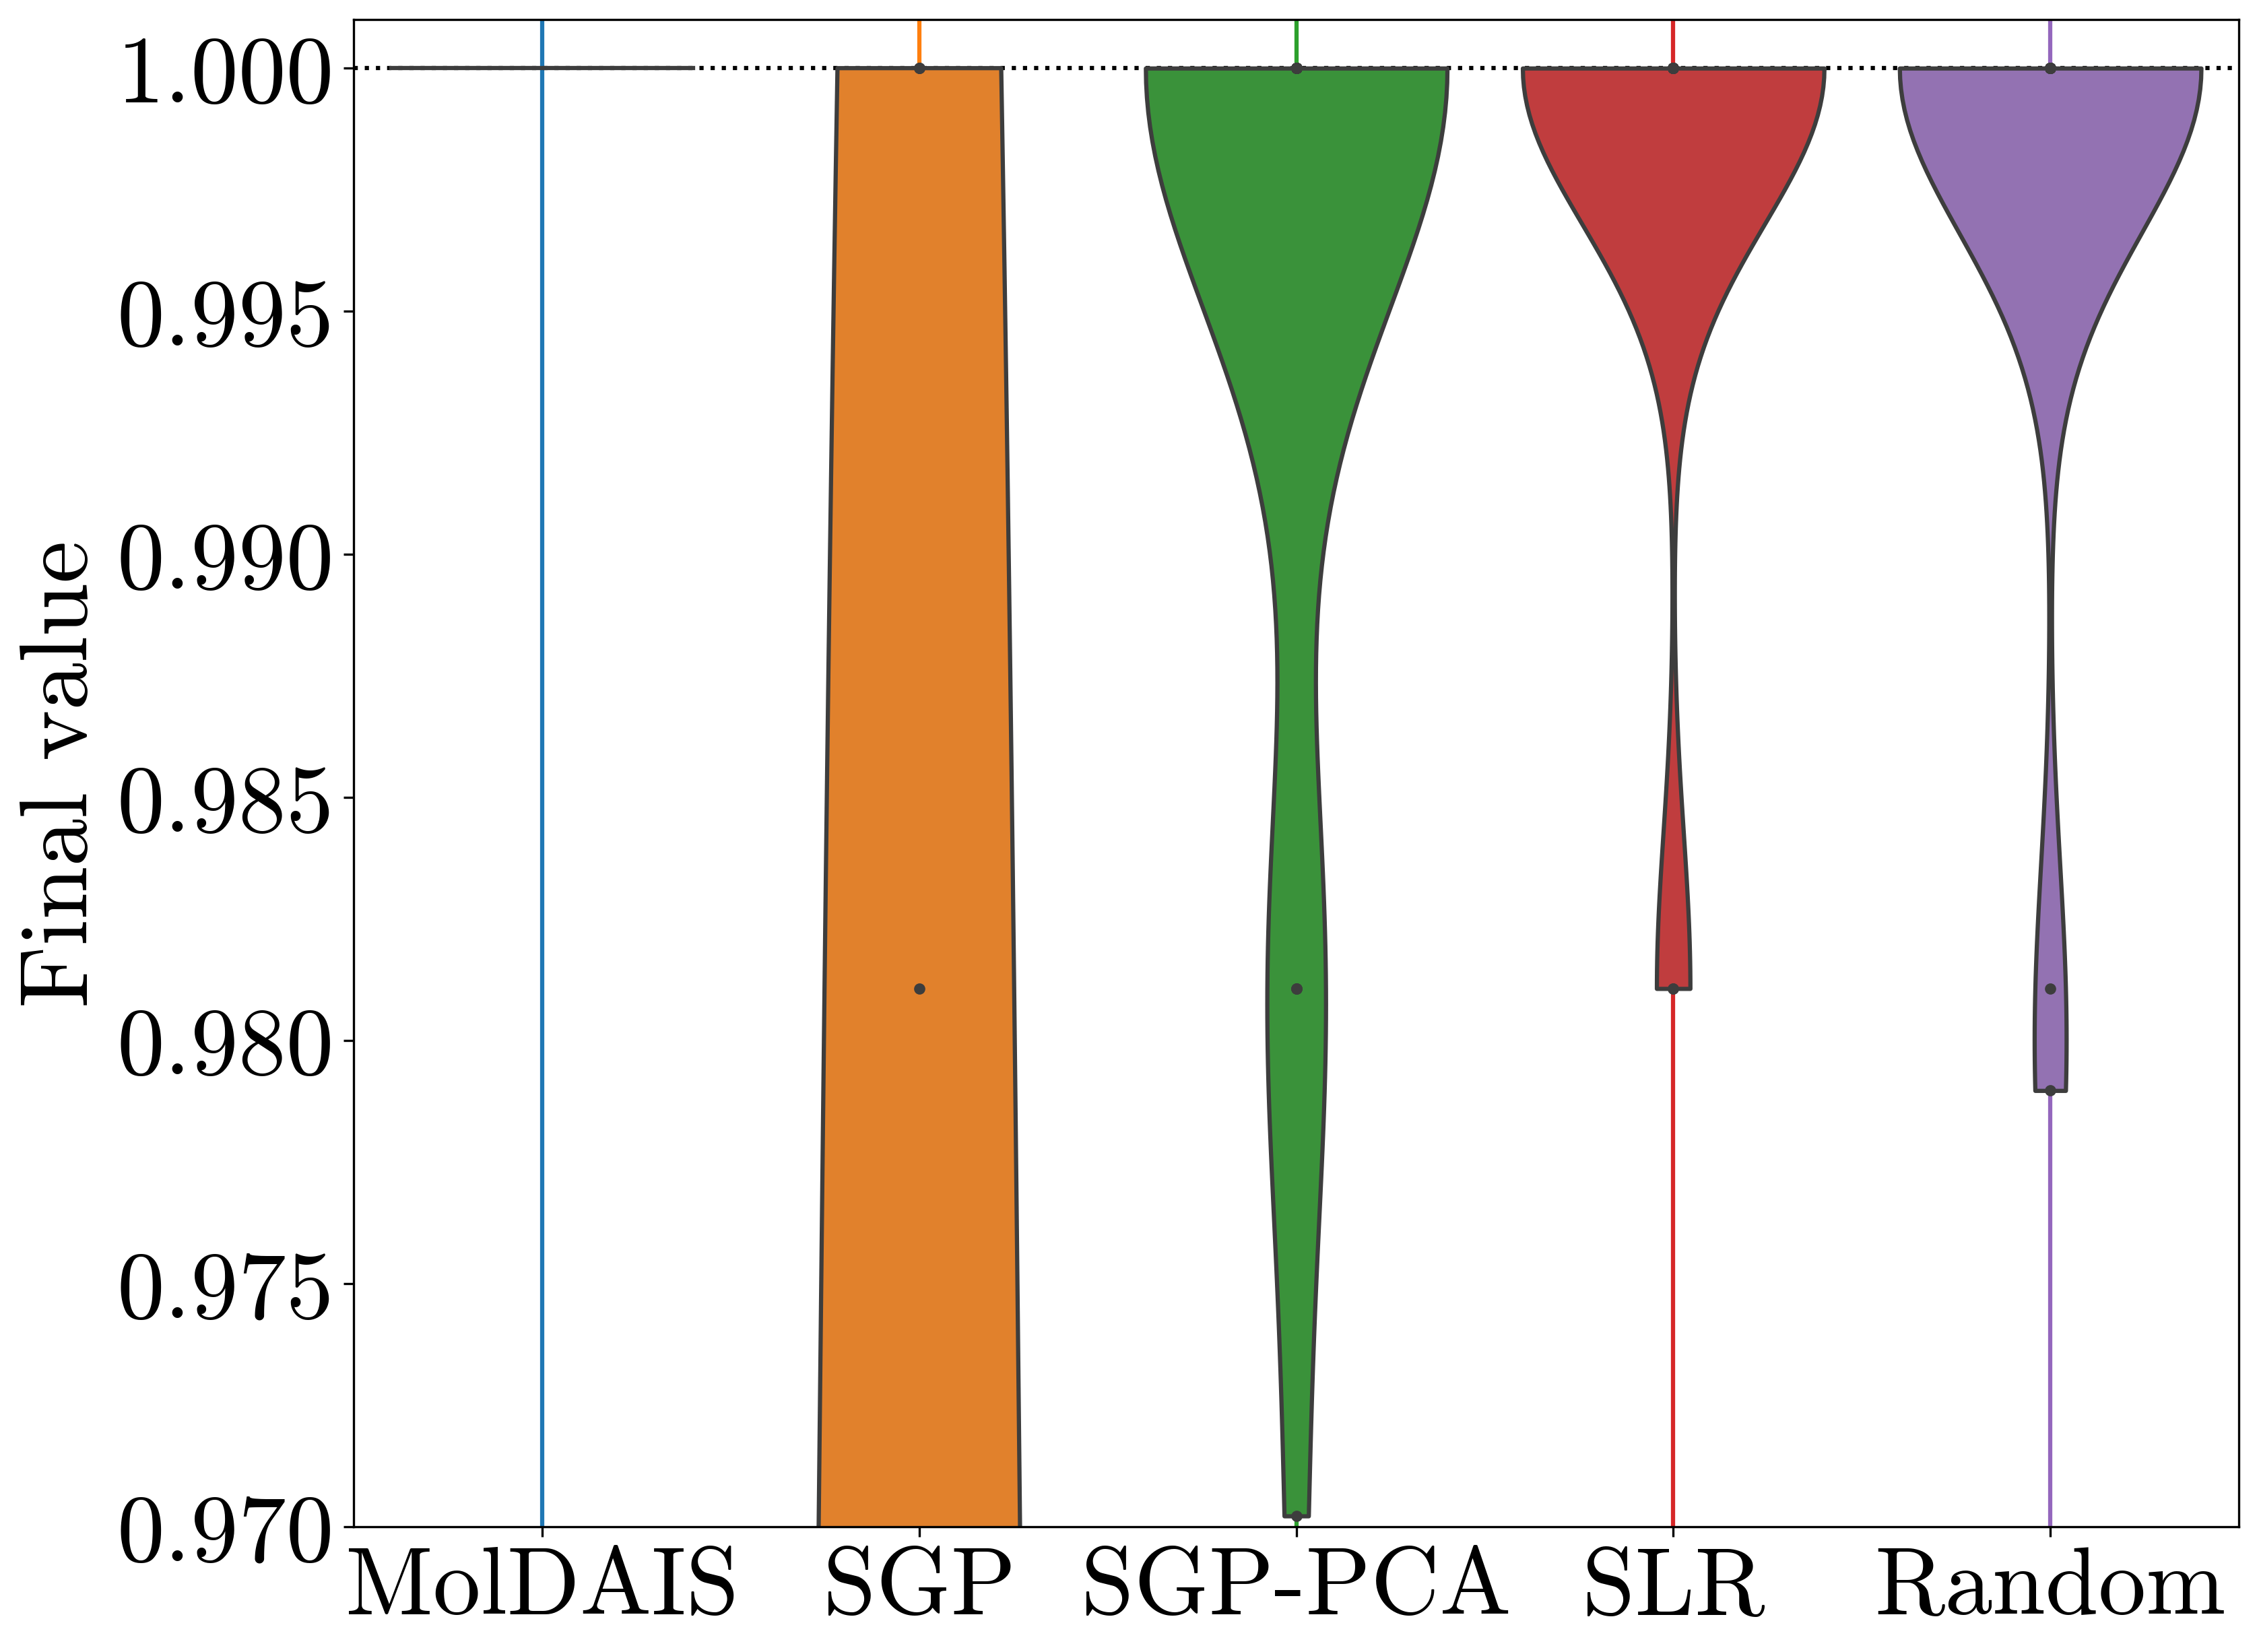

In [325]:
import pandas as pd
import seaborn as sns
sorted_results5 = Res_dict_raw['random']

end = -1
dmin = np.array(df['activity'].to_list()).min()#[df['activity']>=11.]
dmax = np.array(df['activity'].to_list()).max()#[df['activity']>=11.]


df2 = pd.DataFrame()

d =  pd.DataFrame({'Method':[names2[0]]*len(seeds), 'Final value':(sorted_results1[0,:,end]-dmin)/(dmax-dmin)})
df2 = pd.concat([df2, d])

d =  pd.DataFrame({'Method':[names2[1]]*len(seeds), 'Final value':(sorted_results2[0,:,end]-dmin)/(dmax-dmin)})
df2 = pd.concat([df2, d])

d =  pd.DataFrame({'Method':[names2[2]]*len(seeds), 'Final value':(sorted_results3[0,:,end]-dmin)/(dmax-dmin)})
df2 = pd.concat([df2, d])

d =  pd.DataFrame({'Method':[names2[3]]*len(seeds), 'Final value':(sorted_results4[0,:,end]-dmin)/(dmax-dmin)})
df2 = pd.concat([df2, d])

d =  pd.DataFrame({'Method':[names2[4]]*len(seeds), 'Final value':(sorted_results5[0,:,end]-dmin)/(dmax-dmin)})
df2 = pd.concat([df2, d])





C = [ sns.color_palette()[0], sns.color_palette()[1],
     sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[4],
     sns.color_palette()[5], sns.color_palette()[6], sns.color_palette()[6],
     sns.color_palette()[7], sns.color_palette()[8], sns.color_palette()[9],
 '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize=(12,9))
for i,ls in enumerate(range(5)):
  plt.axvline(i, color=C[i], linestyle='-', zorder=0)
plt.axhline(1,color='k', linestyle=':',zorder=0)
sns.violinplot(data=df2, x='Method', y='Final value', cut=0, inner="point", scale='width', palette=C, linestyle='dashdot')
plt.xlabel(None)
#plt.title('Malaria')
#density_norm{“area”, “count”, “width”}
plt.tight_layout()
plt.savefig('./figs/malaria/finalVals.png')


plt.figure(figsize=(12,9))
for i,ls in enumerate(range(5)):
  plt.axvline(i, color=C[i], linestyle='-', zorder=0)
plt.axhline(1,color='k', linestyle=':',zorder=0)
sns.violinplot(data=df2, x='Method', y='Final value', cut=0, inner="point", scale='width', palette=C, linestyle='dashdot')
plt.ylim(.970,1.001)
plt.xlabel(None)
#plt.title('Malaria')
plt.tight_layout()
plt.savefig('./figs/malaria/finalVals_zoom.png')

#density_norm{“area”, “count”, “width”}





In [53]:
df2

,Method,Final value
0,MolDAIS,1.000000
1,MolDAIS,1.000000
2,MolDAIS,1.000000
3,MolDAIS,1.000000
4,MolDAIS,1.000000
0,SGP,0.795486
1,SGP,0.918207
2,SGP,0.929923
3,SGP,0.981067
4,SGP,0.864035
